##### MBA In AI/BigData
### AI in Digital Marketing
#### Topic 1. Attribution modeling
##### March 5, 2022

### Library / data import

In [ ]:
# # This do not persist across cells: use base environment for local runtime
# %%bash
# pwd
# echo $PYTHONPATH
# python --version
# conda --version
# which python
# which conda
# eval "$(conda shell.bash hook)" # copy conda command to shell
# conda activate utils
# conda env list
# which python
# python --version
# # conda list

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io
plotly.io.renderers.default = "colab" # When running local runtime in Colab

import time
from timeit import default_timer as timer

pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.4f}'.format

random_state = 1
np.random.seed = random_state

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import data.json
import json
file_path = '/content/drive/MyDrive/MBA_Business-Classes/data/data.json'
with open(file_path, 'r') as f:
  data = json.load(f)

# # for Google Colab hosted environment
# !pip install igraph cairocffi

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# import json
# file_path = '/content/drive/My Drive/4. 업무공부/MBA/BUS 501/data.json'
# with open(file_path, 'r') as f:
#   data = json.load(f)

### Data processing

In [ ]:
# Categorize marketing channels
def match_category(x):
    result = 'Conversion'
    node_type = {
        'Email': 'Organic',
        'Search': 'Organic',
        'CompanyWebpage': 'Organic',
        'AdWordsKeyword': 'Paid',
        'Movie_PPL': 'Paid',
        'Retargeting': 'Retarget',
        'Youtuber': 'Social',
        'SNS': 'Social',
        'Blogger': 'Social',
        'Influencer': 'Social',
        'Newspaper': 'Paid',
        'TV_Show': 'Paid',
        'PriceCompare': 'Paid',
    }
    for key in node_type.keys():
        if key in x:
            result = node_type[key]
            break
    return result

for node in data['nodes']:
    node['category'] = match_category(node['name'])

# rearrange data structure: list of dict > list of values
node_category = [ele['category'] for ele in data['nodes']]
node_names = [ele['name'] for ele in data['nodes']]
# data error correction
node_names[12] = 'Conversion12' # duplicate Conversion6
node_names[16] = 'Conversion13' # typo: Over generate / export
node_df = pd.DataFrame({'name': node_names, 'category': node_category}) # data type for color is TBD

link_sources = [ele['source'] for ele in data['links']]
link_targets = [ele['target'] for ele in data['links']]
link_values = [ele['value'] for ele in data['links']]
link_df = pd.DataFrame({'source': link_sources, 'target': link_targets, 'value': link_values})

# map custom colors into each node
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
from matplotlib.pyplot import cm

node_count = len(data['nodes'])
node_colors_str = []
node_colors_tuple = []

# differenciate by category
categories = ['Organic', 'Paid', 'Social', 'Retarget', 'Conversion']
category_count = dict([(cat, len(node_df[node_df['category'] == cat])) for cat in categories])
colors = {
    'Organic': iter(cm.Greens(np.linspace(0.3, 1, category_count['Organic']))),
    'Paid': iter(cm.Reds(np.linspace(0.3, 1, category_count['Paid']))),
    'Social': iter(cm.Blues(np.linspace(0.3, 1, category_count['Social']))),
    'Retarget': iter(cm.Oranges(np.linspace(0.3, 1, category_count['Retarget']))),
    'Conversion': iter(cm.Greys(np.linspace(0.3, 1, category_count['Conversion']))),
}
for i in range(node_count):
    for cat in categories:
        if cat == node_category[i]:
            color = colors[cat]
            c_float = next(color) # RGB in float between 0~1
            c_int = c_float * 255 # RGB in int between 0~255
            node_colors_str.append(f'rgb({round(c_int[0])},{round(c_int[1])},{round(c_int[2])})')
            node_colors_tuple.append( (c_float[0], c_float[1], c_float[2]) )

In [ ]:
# Assign index number to node name
index_to_nodename = dict(enumerate(node_names))
link_df['source_idx'] = link_df['source']
link_df['target_idx'] = link_df['target']
link_df['source'] = link_df['source'].map(index_to_nodename)
link_df['target'] = link_df['target'].map(index_to_nodename)


# first touch - middle - last touch 구분
by_source = link_df.groupby(by='source').sum()['value'].to_frame()
by_target = link_df.groupby(by='target').sum()['value'].to_frame()

grouped_node = by_source.join(by_target, how='outer', lsuffix='_source', rsuffix='_target')
grouped_node.loc[(grouped_node['value_source'].isnull()) & (~grouped_node['value_target'].isnull()), 'type'] = 'target'
grouped_node.loc[(~grouped_node['value_source'].isnull()) & (grouped_node['value_target'].isnull()), 'type'] = 'source'
grouped_node['type'].fillna('middle', inplace=True)

node_df['value_source'] = node_df['name'].map(grouped_node['value_source'])
node_df['value_target'] = node_df['name'].map(grouped_node['value_target'])
node_df['type'] = node_df['name'].map(grouped_node['type'])
link_df['source_type'] = link_df['source'].map(grouped_node['type'])
link_df['target_type'] = link_df['target'].map(grouped_node['type'])

link_df['source_category'] = link_df['source'].apply(match_category)
link_df['target_category'] = link_df['target'].apply(match_category)


# local ratio: inflow / outflow ratio in a node
for node in node_df['name']:
    links_ = link_df[link_df['source'] == node].copy()
    link_df.loc[link_df['source'] == node, 'local_ratio_out'] = link_df.loc[link_df['source'] == node, 'value'] / links_['value'].sum()

    links_ = link_df.loc[link_df['target'] == node].copy()
    link_df.loc[link_df['target'] == node, 'local_ratio_in'] = link_df.loc[link_df['target'] == node, 'value'] / links_['value'].sum()
    # link_df.replace([np.inf, -np.inf], np.nan, inplace=True) # nan for first-touches (no inflow)

# only direct conversion links
direct_convert = link_df[link_df['target'].str.contains('Conversion')].copy()

# add up previous channels recursively
source_target_list = link_df[['source', 'target']].set_index('target') # 앞서 거친 단계 확인용
before_join = direct_convert[['source', 'target']].copy()
before_join['source_prev_0'] = before_join['source']
current_order = 1
max_order = 0
while current_order > 0:
    paths_split = before_join.join(source_target_list, how='left', on=f'source_prev_{current_order-1}', rsuffix=f'_prev_{current_order}')
    new_colname = f'source_prev_{current_order}'
    if paths_split[new_colname].isnull().all():
        paths_split.drop(new_colname, inplace=True, axis=1)
        max_order = current_order
        current_order = 0
    else:
        before_join = paths_split
        current_order += 1

# make previous path into 1 column
cols = []
for i in range(max_order):
    cols.append(f'source_prev_{i}')
paths_split['source_all_ordered'] = paths_split[cols].astype(str).apply('+'.join, axis=1).str.replace(r'\+nan','',regex=True)
paths_split['source_all_sorted'] = paths_split['source_all_ordered'].str.split('+').apply(sorted).apply('+'.join)
paths_split['source_count'] = paths_split['source_all_ordered'].str.split('+').apply(len)

# add an order of path to node. It can be different with sankey chart. ex) Email 1)
# reverse_path_index: starts with conversion 0
path_depth = paths_split['source_count'].max()
for i in range(path_depth):
    this_depth = paths_split[f'source_prev_{i}'].unique()
    node_df.loc[node_df['name'].isin(this_depth), 'reverse_path_index'] = i+1
node_df['reverse_path_index'].fillna(0, inplace=True)

# forward path_index
# The difference between order in sankey chart: simple path may be shorter.
# when we use reverse path_index:loop from first touch will be missing simple nodes.
path_depth = 0
links_ = link_df[link_df['source_type'] == 'source']
while True:
    node_df.loc[node_df['name'].isin(links_['source'].to_list()), 'path_index'] = path_depth
    links_ = link_df[link_df['source'].isin(links_['target'].to_list())]
    if links_.empty:
        break
    else:
        path_depth += 1
node_df['path_index'].fillna(7, inplace=True) # Conversion
link_df['path_index'] = link_df['source'].map(node_df.set_index('name')['path_index'])

# 주의: link_df를 덮어쓰므로 항상 위 셀과 함께 실행

<ipython-input-5-fd182b52f7e5>:10: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-5-fd182b52f7e5>:11: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



### Network theory

In [ ]:
!pip install igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 18.1 MB/s eta 0:00:00


In [ ]:
# Construct the graph
from igraph import Graph

link_pairs = zip(link_sources, link_targets)

g = Graph(directed=True)
g.add_vertices(node_count)
g.add_edges(link_pairs)

g.vs['name'] = node_names
g.vs['color'] = node_colors_tuple
g.es['value'] = link_values
print(g)

IGRAPH DN-- 48 68 --
+ attr: color (v), name (v), value (e)
+ edges (vertex names):
TV_Show->Youtuber1, Youtuber1->PriceCompare, Youtuber1->NoConversion,
Youtuber1->Youtuber2, Youtuber1->Youtuber5, Youtuber4->PriceCompare,
Youtuber3->Youtuber2, Email4->Email3, Email2->Email3, Email3->Youtuber2,
Email1->Conversion12, Email1->Conversion3, Email1->Conversion4,
Retargeting1->Conversion13, Retargeting1->Conversion4,
Retargeting1->Retargeting2, Retargeting1->Conversion12,
Retargeting1->Conversion7, Retargeting1->Conversion5,
Retargeting1->Conversion3, Retargeting1->NoConversion,
Retargeting1->Conversion6, Retargeting1->Conversion1,
Retargeting1->Conversion2, AdWordsKeyword1->AdWordsKeyword2,
AdWordsKeyword3->AdWordsKeyword2, Youtuber5->Conversion3,
Youtuber5->NoConversion, Youtuber5->Search1, Youtuber5->Conversion5,
Youtuber5->Conversion12, Movie_PPL->Retargeting1, Retargeting2->SNS4,
Retargeting2->NoConversion, SNS4->Conversion7, SNS3->Retargeting1,
PriceCompare->Conversion12, PriceCompare-

In [ ]:
# https://networkx.org/documentation/stable/tutorial.html
import networkx as nx
ng = nx.DiGraph()

#  ('Retargeting2', {'color': (0.4980392156862745, 0.15294117647058825, 0.01568627450980392)}),
nodes_ = list(zip(node_names, [{'color': ele} for ele in node_colors_tuple]))
ng.add_node(1)
ng.add_nodes_from(nodes_)

edges_ = list(zip(link_sources, link_targets, [{'value': ele} for ele in link_values]))
ng.add_edges_from(edges_)

ng.nodes.data
ng.edges.data
ng.edges[1, 2]

{'value': 0.597}

In [ ]:
# Get the adjacency matrix
print(g.get_adjacency()[:10])

[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

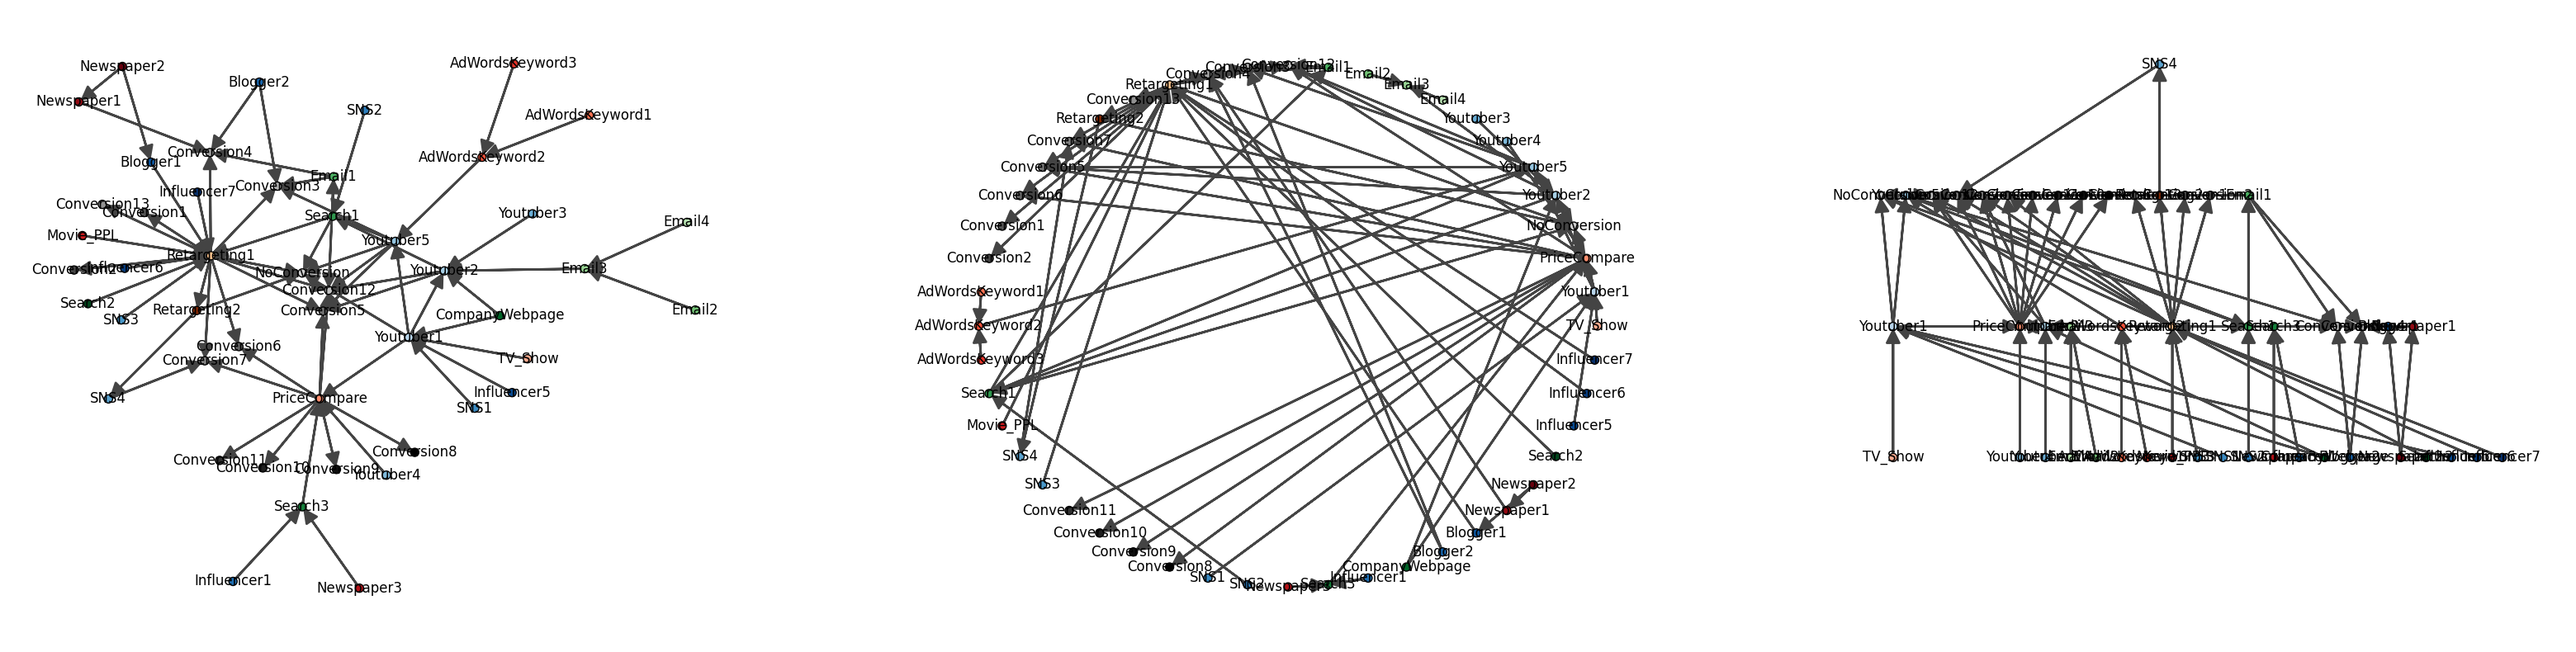

In [ ]:
# Plot the network by predefined layouts
# https://igraph.org/python/tutorial/latest/tutorial.html
from igraph import plot

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(40, 10)

vertex_style = {
    'vertex_label': g.vs['name'],
    'vertex_color': g.vs['color'],
    'vertex_size': 10,
    'margin': 30,
}

plot(g, layout=g.layout("kamada_kawai"), **vertex_style, target=ax1)
plot(g, layout=g.layout("circle"), **vertex_style, target=ax2)
plot(g, layout=g.layout("tree"), **vertex_style, target=ax3)

for ax in (ax1, ax2, ax3):
    ax.tick_params(which='both',
      left=False, bottom=False,
      labelleft=False, labelbottom=False
    )

plt.show()

In [ ]:
# eigenvector centrality

g2 = Graph(directed=True)
g2.add_vertices(node_count)
g2.add_edges(link_pairs)

g2.vs['name'] = node_names
g2.vs['color'] = node_colors_tuple
g2.es['value'] = link_values

# g2.evcent()

#### Check data consistency

In [ ]:
# Sum of values assigned to the noded with out-degree only
target_sum = 0
for i in range(len(g.vs)):
    if g.vs[i].degree(mode='in') == 0:
        incoming_links = g.es.select(_source=g.vs[i].index).get_attribute_values('value')
        target_sum += sum(incoming_links)

# in-degree only
source_sum = 0
for i in range(len(g.vs)):
    if g.vs[i].degree(mode='out') == 0:
        outgoing_links = g.es.select(_target=g.vs[i].index).get_attribute_values('value')
        source_sum += sum(outgoing_links)

print(f'Sum of source values: {source_sum}, Sum of target values: {target_sum}')

# check the middle node that sum of source is not the same with that of target
unmatched_flow = node_df[(node_df['type'] == 'middle') & (node_df['value_source'] != node_df['value_target'])]
unmatched_flow # Error at Retargeting1 (inflow > outflow)

Sum of source values: 2842.038, Sum of target values: 2840.7030000000004


,name,category,value_source,value_target,type,reverse_path_index,path_index
1,Youtuber1,Social,388.9250,388.9240,middle,6.0000,1.0000
4,Youtuber2,Social,447.4790,447.4800,middle,5.0000,2.0000
5,Youtuber5,Social,204.0970,204.0960,middle,5.0000,2.0000
11,Email1,Organic,79.3280,79.3290,middle,1.0000,4.0000
15,Retargeting1,Retarget,918.6070,917.2710,middle,3.0000,4.0000
17,Retargeting2,Retarget,27.1390,27.1400,middle,2.0000,5.0000


### Sankey diagram

In [ ]:
# Sankey diagram
# https://plotly.com/python/sankey-diagram/

def draw_sankey(link_df, title, width=1000, height=800):

    fig = go.Figure(data=[go.Sankey(
        valueformat = '.3f',
        valuesuffix = ' flow',
        node = dict(
            pad = 15,
            thickness = 15,
            line = dict(color = 'black', width = 0.5),
            label = node_names,
            color = node_colors_str,
        ),
    link = dict(
        source = link_df['source_idx'],
        target = link_df['target_idx'],
        value = link_df['value'],
    )
    )])

    fig.update_layout(
        title_text=title,
        font_size=10,
        autosize=False,
        width=width,
        height=height)
    fig.show()

draw_sankey(link_df, 'Sankey diagram (1): Flow data for touch points')

#### Sankey diagram - except NoConversion

In [ ]:
# Sankey diagram
# https://plotly.com/python/sankey-diagram/
import plotly.graph_objects as go

# nodes & links except NoConversion
node_df['color'] = node_colors_str
node_df_exc = node_df[node_df['name'] != 'NoConversion']
node_names_exc = node_df_exc['name']
node_colors_str_exc = node_df_exc['color']

link_df_exc = link_df[link_df['target_idx'] != 3] # index of NoConversion
# rearrange broken index by removing 3
link_sources_exc = link_df_exc['source_idx'].where(link_df_exc['source_idx'] < 3, other=link_df_exc['source_idx'] - 1)
link_targets_exc = link_df_exc['target_idx'].where(link_df_exc['target_idx'] < 3, other=link_df_exc['target_idx'] - 1)
link_values_exc = link_df_exc['value']

fig = go.Figure(data=[go.Sankey(
    valueformat = '.3f',
    valuesuffix = ' flow',
    node = dict(
    pad = 15,
    thickness = 15,
    line = dict(color = 'black', width = 0.5),
    label = node_names_exc,
    color = node_colors_str_exc,
  ),
  link = dict(
    source = link_sources_exc,
    target = link_targets_exc,
    value = link_values_exc,
  )
)])

fig.update_layout(
    title_text='Sankey diagram (2): Flow data for touch points (except NoConversion)',
    font_size=10,
    autosize=False,
    width=1000,
    height=800)
fig.show()

#### Sankey diagram - divided into Conversion / NoConversion

In [ ]:
# didn't refer to index - so if there are deletion/addition of items, reset and re-map index.

node_df_binary = node_df.copy()
node_df_binary['name'].replace(regex=r'Conversion\d{1,2}', value='Conversion', inplace=True)

link_df_binary = link_df.copy()
link_df_binary['source'] = link_df_binary['source_idx'].map(node_df_binary['name'])
link_df_binary['target'] = link_df_binary['target_idx'].map(node_df_binary['name'])

conversion_idx = node_df_binary[node_df_binary['name'] == 'Conversion'].index
noconversion_idx = node_df_binary[node_df_binary['name'] == 'NoConversion'].index

node_df_binary.drop(index=conversion_idx, inplace=True)
node_df_binary = node_df_binary.append({'name': 'Conversion', 'category': 'Conversion', 'color': 'rgb(194,194,194)'}, ignore_index=True)

node_df_binary.reset_index(inplace=True)
node_df_binary.drop('index', inplace=True, axis=1)

link_df_binary['source_idx'] = link_df_binary['source'].map(node_df_binary.reset_index().set_index('name')['index'])
link_df_binary['target_idx'] = link_df_binary['target'].map(node_df_binary.reset_index().set_index('name')['index'])


fig = go.Figure(data=[go.Sankey(
    valueformat = '.3f',
    valuesuffix = ' flow',
    node = dict(
    pad = 15,
    thickness = 15,
    line = dict(color = 'black', width = 0.5),
    label = node_df_binary['name'],
    color = node_df_binary['color'],
  ),
  link = dict(
    source = link_df_binary['source_idx'],
    target = link_df_binary['target_idx'],
    value = link_df_binary['value'],
  )
)])

fig.update_layout(
    title_text='Sankey diagram (3): Flow data for touch points (Conversion / NoConversion)',
    font_size=10,
    autosize=False,
    width=1000,
    height=800)
fig.show()

<ipython-input-16-102e07dedb1d>:14: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



### How to calculate Shapley value

#### Reproduce reference code (1)

In [ ]:
# Shapley value without order consideration
# https://medium.com/analytics-vidhya/the-shapley-value-approach-to-multi-touch-attribution-marketing-model-e345b35f3359

import itertools
from collections import defaultdict
from itertools import permutations, combinations

def factorial(n):
  if n == 0:
    return 1
  else:
    return n * factorial(n-1)

def combinations_of(l):
  """
  All possible combinations of the given list
    l: list
    return: list of lists
  """
  return [list(j) for i in range(len(l)) for j in itertools.combinations(l, i+1)]

def subsets_of(players):
  """
  All possible subsets of the given list of players
    players: list, a set of players
    return: list
  """
  if len(players) == 1:
      return players
  else:
      subsets = []
      for i in range(1, len(players)+1):
          subsets.extend(map(list,itertools.combinations(players, i)))
  return list(map(",".join,map(sorted, subsets)))

def value_function(coalition, contribution_data):
  """
  Characteristic function which computes the aggregated worth of given coalition
    coalition : list
    conversion : dict, coalition-conversion pair
  """
  subsets = subsets_of(coalition)
  # print(subsets)
  sum_of_worth = 0
  for subset in subsets:
    if subset in contribution_data: # based on the existing data: missing subsets?
      sum_of_worth += contribution_data[subset]
  return sum_of_worth

def calculate_shapley(df, key_name, value_name):
  """
  Calculate the shapley values
    df: dataframe, with columns of player subsets and corresponding contribution values
    key_name: string, key of contribution_data
    value_name: string, value of contribution_data
  """
  # Extract standalone players
  contribution_data = df.set_index(key_name).to_dict()[value_name] # {'email,instagram': 10}
  df['standalone_only'] = df[key_name].apply(lambda x: x if len(x.split(',')) == 1 else np.nan)
  players = list(df['standalone_only'].dropna().unique()) # ['email', 'instagram']

  # Calculate all coalition subset's worth
  coalition_contribution = {}
  for coalition in combinations_of(players):
    coalition_contribution[','.join(sorted(coalition))] = value_function(coalition, contribution_data)

  # Calculate marginal contribution of a player
  n = len(players)
  shapley_values = defaultdict(int) # undefined value will be set to 0 (for the missing subsets)
  for player in players:
      for coalition in coalition_contribution.keys():
          if player not in coalition.split(","): # For all coalitions in which the player is not included
              coalition_cardinality = len(coalition.split(",")) # cardinality = the size of coalition
              # Add the player to the existing coalition
              coalition_players = coalition.split(",")
              coalition_players.append(player)
              coalition_players = ",".join(sorted(coalition_players))
              # weight = |S|!(n-|S|-1)!/n!
              weight = (factorial(coalition_cardinality)*factorial(n-coalition_cardinality-1)/factorial(n))
              # marginal contribution = v(S U {i})-v(S)
              contrib = (coalition_contribution[coalition_players]-coalition_contribution[coalition])
              shapley_values[player] += weight * contrib
      # Add the term corresponding to the empty(missing) coalition subsets
      shapley_values[player] += coalition_contribution[player]/n

  return shapley_values

print(combinations_of([1,2,3,4,5]))
len(combinations_of([1,2,3,4,5]))

[[1], [2], [3], [4], [5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5], [1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 3, 4], [1, 3, 5], [1, 4, 5], [2, 3, 4], [2, 3, 5], [2, 4, 5], [3, 4, 5], [1, 2, 3, 4], [1, 2, 3, 5], [1, 2, 4, 5], [1, 3, 4, 5], [2, 3, 4, 5], [1, 2, 3, 4, 5]]


31

#### Reproduce reference code (2)

In [ ]:
# Check if the result with medium data is the same or not.
# https://github.com/jrkinley/game-theory-attribution/blob/main/game_theory_attribution.ipynb

import numpy as np
import pandas as pd
from itertools import combinations
from collections import defaultdict
from math import factorial

def subsets(S):
    '''Returns all possible subsets of the given set'''
    s = []
    for i in range(1, len(S)+1):
        s.extend(map(list, combinations(S, i)))
    return list(map('+'.join, s))

def calculate_shapley2(data, players, source, value):

    N = players

    coalitions = subsets(N)
    coalitions_lbl = ['S{}'.format(i) for i in range(1, len(coalitions)+1)]

    # IR = np.array([0.18, 0.04, 0.08, 0.1, 0.26, 0.07, 0.27])
    contribution = pd.DataFrame(coalitions, columns=[source])
    contribution[value] = contribution[source].map(data.set_index(source)[value])
    contribution[value].fillna(0, inplace=True)
    IR = contribution[value].to_list()

    # B is binary squared matrix that represents coalition membership.
    # For example, coalition Facebook+LinkedIn (S5) includes members:
    # - Facebook (S1)
    # - LinkedIn (S3)
    # - Facebook+LinkedIn (S5)
    # Resulting in the coefficients: [1,0,1,0,1,0,0]

    d = 2**len(N)-1
    B = np.matrix(np.zeros((d, d)))

    for i in range(0, d):
        A = coalitions[i]
        S = subsets(A.split('+'))
        coef = [1 if c in S else 0 for c in coalitions]
        B[i] = coef

    pd.options.display.float_format = '{:,.0f}'.format
    pd.DataFrame(data=B, index=coalitions, columns=coalitions)

    # The product of the matrices coalition membership and coalition ratios
    # is the coalition worth - the result of the characteristic function 'v(S)'

    vS = np.dot(B, IR)
    vS = np.squeeze(np.asarray(vS))

    vSx = ['v({})'.format(lbl) for lbl in coalitions_lbl]
    pd.options.display.float_format = '{:,.2f}'.format
    pd.DataFrame({
    'Coalition': coalitions,
    'Worth': vS
    }, index=vSx)

    from collections import defaultdict
    from math import factorial

    # Calculate the Shapley values - the average value of each channel's marginal contribution
    # to the grand coalition, taking into account all possible orderings.

    shapley = defaultdict(int)
    n = len(N)

    for i in N:
        for A in coalitions:
            S = A.split('+')
            if i not in S:
                k = len(S) # Cardinality of set |S|
                Si = S
                Si.append(i)
                Si = '+'.join(sorted(Si))
                # Weight = |S|!(n-|S|-1)!/n!
                weight = (factorial(k) * factorial(n-k-1)) / factorial(n)
                # Marginal contribution = v(S U {i})-v(S)
                contrib = vS[coalitions.index(Si)] - vS[coalitions.index(A)]
                shapley[i] += weight * contrib
        shapley[i] += vS[coalitions.index(i)]/n

    return pd.DataFrame({
        'Shapley value': list(shapley.values())
    }, index=list(shapley.keys()))

#### Do (1) and (2) yield the same result?

In [ ]:
# Sample data
# https://medium.com/analytics-vidhya/the-shapley-value-approach-to-multi-touch-attribution-marketing-model-e345b35f3359

medium_data = pd.DataFrame({
  'sources': ['Facebook','Instagram','House Ads','Push','House Ads,Push','Facebook,House Ads','House Ads,Instagram','Email','Email,Instagram','Email,Facebook','Email,House Ads','Facebook,Push','Facebook,Instagram','Instagram,Push','Email,Push'],
  'value': [103,57,280,22,46, 72,103,110,10,11,40,22,62,21,4]
})
shapley_value = calculate_shapley(medium_data, 'sources', 'value')
print(shapley_value)

defaultdict(<class 'int'>, {'Facebook': 186.50000000000003, 'Instagram': 155.0, 'House Ads': 410.5, 'Push': 68.5, 'Email': 142.5})


In [ ]:
medium_data['sources'] = medium_data['sources'].str.replace(',', '+')

shapley_value2 = calculate_shapley2(
    medium_data,
    ['Email', 'Facebook', 'House Ads', 'Instagram', 'Push'],
    'sources',
    'value'
)
print(shapley_value2)

           Shapley value
Email             142.50
Facebook          186.50
House Ads         410.50
Instagram         155.00
Push               68.50


#### Trial 1: Traditional approach

* Failed with error: memory exceeded
* Reason: All possible combinations (coalition) of N players is huge
* Then what?
1. Simplified Shapley value model
2. Combine groups
3. Programatic trick: save data into stroage, not memory
4. Sub-game based approach, which we have covered in the lecture

#### Trial 2: Subgame approach

* Loop over all subsets of Grand coalition
* Loop over all subsets of individual coalitions

For every $S \subseteq N$: \
$\quad$ if $v(S) - accum(S) \neq 0$: \
$\quad\quad$ For every $T \subseteq S$ \
$\quad\quad\quad$ $x(T) = v(S) - accum(S)$ \
$\quad\quad\quad$ $accum(S) = accum(S) + x(T)$

In [ ]:
def calculate_shapley_by_subgame(df_vS):
    """
    Calculate Shapley value by sub-game approach
    Inputs
    - df_vS: DataFrame with coalition - v(S) pair
    """

    vAll = df_vS.copy()
    N = sorted(list(set('+'.join(vAll.index).split('+')))) # unique agents
    # calculation based on given coalitions: not the all possible combinations of Grand coalition
    S = vAll.index.to_list()
    vAll.columns = ['vS']
    vAll['accum'] = 0
    shapley = pd.DataFrame(np.zeros((len(N), len(S))), index=N, columns=S) # agents X coalition

    # calculate marginal contribution
    xT = pd.DataFrame(np.zeros((len(S), len(S))), index=S, columns=S)
    for s in S: # S ⊆ N (s = check marginal contribution)
        # stop if accum is full
        if vAll.loc[s,'vS'] != vAll.loc[s,'accum']:
            for t in S: # T ⊆ S (T = subset of grand coalition)
                # update coalition which contains s as element
                if set(s.split('+')).issubset(t.split('+')):
                    xT.loc[t,s] = vAll.loc[s,'vS'] - vAll.loc[s,'accum']
            # update accum in all S, if s is included
            includes_s = [set(s.split('+')).issubset(s_list) for s_list in vAll.index.str.split('+')]
            vAll.loc[includes_s, 'accum'] += xT.loc[t,s]

    # distribute marginal contribution to agents
    for s in S:
        include_s = [set(s.split('+')).issubset(s_list) for s_list in xT.index.str.split('+')]
        contribution = xT.loc[include_s, s].mean(axis=0)
        # distribute equally to the all agents included in subset s
        for agent in N:
            if agent in s.split('+'):
                shapley.loc[agent, s] = contribution / len(s.split('+'))

    return shapley.sum(axis=1).to_frame(name='shapley_value')

In [ ]:
# Test with Lecture example (1)
lecture_data_1 = pd.DataFrame(
    {'vS': [10, 20, 0, 30, 30, 40, 70]},
    index=['A', 'B', 'C', 'A+B', 'A+C', 'B+C', 'A+B+C'],
)
shapley_value = calculate_shapley_by_subgame(lecture_data_1)
print(shapley_value)

# Test with Lecture example (2)
lecture_data_1 = pd.DataFrame(
    {'vS': [0, 0, 100, 300, 200, 100, 500]},
    index=['A', 'B', 'C', 'A+B', 'A+C', 'B+C', 'A+B+C'],
)
shapley_value = calculate_shapley_by_subgame(lecture_data_1)
print(shapley_value)

   shapley_value
A          20.00
B          30.00
C          20.00
   shapley_value
A         200.00
B         150.00
C         150.00


### Assumptions for Questions

In [ ]:
# Copy & Paste from Google sheets
# https://docs.google.com/spreadsheets/d/16hTAc7Pn0I6piBQ4Xpbj35aZWXxn8sPycwKnFEVeRlw/edit#gid=107363863

# Marketing budget allocation throughout channels (CHF)
budget_allocation = {
'TV_Show': [100,0,32.75,32.75,32.75,0,32.75,32.75,32.75,32.75,32.75,2.43,0.13,0.00],
'Youtuber1': [100,0,147.05,147.05,147.05,0,147.05,147.05,147.05,147.05,147.05,92.95,40.90,32.12],
'PriceCompare': [100,1053.05,153.58,153.58,153.58,1053.05,153.58,153.58,153.58,153.58,153.58,70.48,18.80,13.08],
'Youtuber2': [100,186.69,169.18,169.18,169.18,186.69,169.18,169.18,169.18,169.18,169.18,88.59,33.01,26.94],
'Youtuber5': [100,115.25,69.59,69.59,69.59,115.25,69.59,69.59,69.59,69.59,69.59,77.53,66.76,50.07],
'Youtuber4': [100,0,18.93,18.93,18.93,0,18.93,18.93,18.93,18.93,18.93,4.38,0.54,0.00],
'Youtuber3': [100,0,19.77,19.77,19.77,0,19.77,19.77,19.77,19.77,19.77,4.43,0.48,0.00],
'Email4': [100,0,2.38,2.38,2.38,0,2.38,2.38,2.38,2.38,2.38,0.03,0.00,0.00],
'Email3': [100,0,16.46,16.46,16.46,0,16.46,16.46,16.46,16.46,16.46,0.95,0.04,0.00],
'Email2': [100,0,14.07,14.07,14.07,0,14.07,14.07,14.07,14.07,14.07,0.92,0.04,0.00],
'Email1': [100,12.76,29.31,29.31,29.31,12.76,29.31,29.31,29.31,29.31,29.31,18.91,14.25,12.55],
'Retargeting1': [100,1354.4,616.32,616.32,616.32,1354.4,616.32,616.32,616.32,616.32,616.32,824.97,976.16,1159.32],
'Retargeting2': [100,0,348.50,348.50,348.50,0,348.50,348.50,348.50,348.50,348.50,489.29,581.93,468.76],
'AdWordsKeyword1': [100,0,16.39,16.39,16.39,0,16.39,16.39,16.39,16.39,16.39,12.80,6.67,4.91],
'AdWordsKeyword2': [100,0,50.10,50.10,50.10,0,50.10,50.10,50.10,50.10,50.10,67.06,58.30,44.89],
'AdWordsKeyword3': [100,0,33.71,33.71,33.71,0,33.71,33.71,33.71,33.71,33.71,54.25,51.64,39.98],
'Search1': [100,0,291.17,291.17,291.17,0,291.17,291.17,291.17,291.17,291.17,156.38,88.84,64.24],
'Movie_PPL': [100,0,3.79,3.79,3.79,0,3.79,3.79,3.79,3.79,3.79,0.03,0.00,0.00],
'SNS4': [100,1.46,163.57,163.57,163.57,1.46,163.57,163.57,163.57,163.57,163.57,177.64,297.76,198.24],
'SNS3': [100,0,7.37,7.37,7.37,0,7.37,7.37,7.37,7.37,7.37,0.25,0.00,0.00],
'SNS1': [100,0,2.20,2.20,2.20,0,2.20,2.20,2.20,2.20,2.20,0.02,0.00,0.00],
'SNS2': [100,0,97.39,97.39,97.39,0,97.39,97.39,97.39,97.39,97.39,36.20,9.04,6.05],
'Newspaper3': [100,0,93.47,93.47,93.47,0,93.47,93.47,93.47,93.47,93.47,49.34,13.89,9.63],
'Search3': [100,0,134.65,134.65,134.65,0,134.65,134.65,134.65,134.65,134.65,66.10,18.26,13.08],
'Influencer1': [100,0,41.18,41.18,41.18,0,41.18,41.18,41.18,41.18,41.18,16.76,4.37,3.45],
'CompanyWebpage': [100,0,22.85,22.85,22.85,0,22.85,22.85,22.85,22.85,22.85,3.05,0.18,0.00],
'Blogger2': [100,670.33,288.90,288.90,288.90,670.33,288.90,288.90,288.90,288.90,288.90,280.01,157.39,103.15],
'Blogger1': [100,0,39.13,39.13,39.13,0,39.13,39.13,39.13,39.13,39.13,5.23,0.40,0.00],
'Newspaper1': [100,6.05,1.30,1.30,1.30,6.05,1.30,1.30,1.30,1.30,1.30,0.17,0.01,0.00],
'Newspaper2': [100,0,40.44,40.44,40.44,0,40.44,40.44,40.44,40.44,40.44,5.39,0.42,0.00],
'Search2': [100,0,5.02,5.02,5.02,0,5.02,5.02,5.02,5.02,5.02,0.10,0.00,0.00],
'Influencer5': [100,0,94.64,94.64,94.64,0,94.64,94.64,94.64,94.64,94.64,88.19,40.64,32.12],
'Influencer6': [100,0,21.83,21.83,21.83,0,21.83,21.83,21.83,21.83,21.83,3.30,0.31,0.00],
'Influencer7': [100,0,313.00,313.00,313.00,0,313.00,313.00,313.00,313.00,313.00,701.87,918.81,1117.40],
}
# Advertising cost for channels (CHF)
channel_cost = {
'TV_Show': [100,100,100,236,207.2,100,100,236,207.2,236,207.2,207.2,207.2,207.2],
'Youtuber1': [100,100,100,59,51.8,100,100,59,51.8,59,51.8,51.8,51.8,51.8],
'PriceCompare': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'Youtuber2': [100,100,100,59,51.8,100,100,59,51.8,59,51.8,51.8,51.8,51.8],
'Youtuber5': [100,100,100,59,51.8,100,100,59,51.8,59,51.8,51.8,51.8,51.8],
'Youtuber4': [100,100,100,59,51.8,100,100,59,51.8,59,51.8,51.8,51.8,51.8],
'Youtuber3': [100,100,100,59,51.8,100,100,59,51.8,59,51.8,51.8,51.8,51.8],
'Email4': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'Email3': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'Email2': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'Email1': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'Retargeting1': [100,100,100,118,310.8,100,100,118,310.8,118,310.8,310.8,310.8,310.8],
'Retargeting2': [100,100,100,118,310.8,100,100,118,310.8,118,310.8,310.8,310.8,310.8],
'AdWordsKeyword1': [100,100,100,11.8,10.36,100,100,11.8,10.36,11.8,10.36,10.36,10.36,10.36],
'AdWordsKeyword2': [100,100,100,11.8,10.36,100,100,11.8,10.36,11.8,10.36,10.36,10.36,10.36],
'AdWordsKeyword3': [100,100,100,11.8,10.36,100,100,11.8,10.36,11.8,10.36,10.36,10.36,10.36],
'Search1': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'Movie_PPL': [100,100,100,236,207.2,100,100,236,207.2,236,207.2,207.2,207.2,207.2],
'SNS4': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'SNS3': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'SNS1': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'SNS2': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'Newspaper3': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'Search3': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'Influencer1': [100,100,100,59,51.8,100,100,59,51.8,59,51.8,51.8,51.8,51.8],
'CompanyWebpage': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'Blogger2': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'Blogger1': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'Newspaper1': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'Newspaper2': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'Search2': [100,100,100,118,103.6,100,100,118,103.6,118,103.6,103.6,103.6,103.6],
'Influencer5': [100,100,100,59,51.8,100,100,59,51.8,59,51.8,51.8,51.8,51.8],
'Influencer6': [100,100,100,59,51.8,100,100,59,51.8,59,51.8,51.8,51.8,51.8],
'Influencer7': [100,100,100,59,51.8,100,100,59,51.8,59,51.8,51.8,51.8,51.8],
}
# Product sales price for conversion channels
conversion_price = {
'Conversion1': [100,100,100,100,100,50,50,50,50,50,50,50,45,45],
'Conversion2': [100,100,100,100,100,55,55,55,55,55,55,55,49.5,49.5],
'Conversion3': [100,100,100,100,100,60,60,60,60,60,60,60,54,54],
'Conversion4': [100,100,100,100,100,65,65,65,65,65,65,65,58.5,58.5],
'Conversion5': [100,100,100,100,100,70,70,70,70,70,70,70,63,63],
'Conversion6': [100,100,100,100,100,75,75,75,75,75,75,75,67.5,67.5],
'Conversion7': [100,100,100,100,100,80,80,80,80,80,80,80,72,72],
'Conversion8': [100,100,100,100,100,85,85,85,85,85,85,85,76.5,76.5],
'Conversion9': [100,100,100,100,100,90,90,90,90,90,90,90,81,81],
'Conversion10': [100,100,100,100,100,95,95,95,95,95,95,190,114,114],
'Conversion11': [100,100,100,100,100,100,100,100,100,100,100,200,120,120],
'Conversion12': [100,100,100,100,100,100,100,100,100,100,100,100,90,90],
'Conversion13': [100,100,100,100,100,100,100,100,100,100,100,100,90,90],
'NoConversion': [0,0,0,0,0,0,0,0,0,0,0,0,0,0],
}
print(f'Scenario count: {len(budget_allocation["TV_Show"])}')

def apply_assumption(assumption):
    """
    Update link_df, node_df as per cost (efficiency) and budget assignment defined by scenarios
    - channel_efficiency: value output over cost input
    - expected_value: budget assigned to channel * cost efficiency
    - conversion_value: value * converion_price
    - eigen_centrality: additional info
    """
    budget = pd.DataFrame(budget_allocation).iloc[assumption]
    cost = pd.DataFrame(channel_cost).iloc[assumption]
    conversion = pd.DataFrame(conversion_price).iloc[assumption]

    # add colum to existing node_df, link_df
    # caution: we calculate all links but, in simulation, we use only information of first touch
    node = node_df
    link = link_df

    # cost efficiency = value / cost
    # Requires a linear assumption that marginal utility is the same for additional input costs
    node['channel_cost'] = node['name'].map(cost)
    node['budget_allocated'] = node['name'].map(budget)
    # first touch: in aspect of total outflow, middle: in aspect of total inflow
    node['channel_efficiency'] = np.where(
        node['type'] == 'source',
        node['value_source'] / node['channel_cost'],
        node['value_target'] / node['channel_cost']
    )
    # expected value by new cost & budget
    link['channel_cost'] = link['source'].map(node.set_index('name')['channel_cost']) * link['local_ratio_out']
    link['channel_efficiency'] = link['source'].map(node.set_index('name')['channel_efficiency'])

    link['budget_allocated'] = link['source'].map(node.set_index('name')['budget_allocated']) * link['local_ratio_out']
    link['expected_value'] = link['budget_allocated'] * link['channel_efficiency']

    # conversion price & value
    # link: if it is not direct conversion, then NaN
    link['conversion_price'] = link['target'].map(conversion)
    link['conversion_value'] = link['expected_value'] * link['conversion_price']
    conversion_value_sum_ = link_df[link_df['target_type'] == 'Conversion'].groupby(by='target')['conversion_value'].sum()
    node['conversion_value'] = node_df['name'].map(conversion_value_sum_)

    return None


# check if assumption data is set as intended
def check_assumption(assumption):
    name = [k for k, v in budget_allocation.items()]
    budget = [v[assumption] for k, v in budget_allocation.items()]
    cost = [v[assumption] for k, v in channel_cost.items()]

    return pd.DataFrame({'budget_allocation': budget, 'channel_cost': cost}, index=name)

Scenario count: 14


### Simulation: data Resampling

#### Concept: logged & simple growth rate

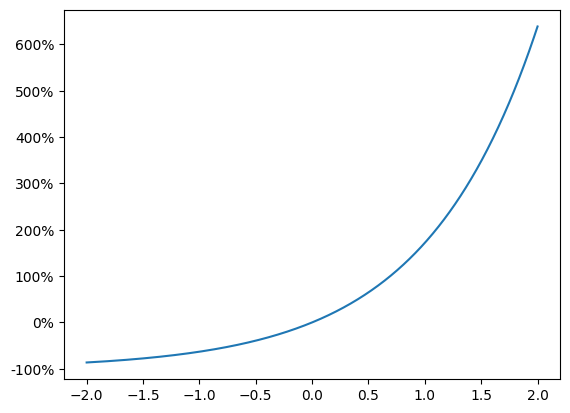

In [ ]:
# std dev of expected log change of value by category
# pct change = np.exp(log change)
# ex) 100 > 150: pct change is 50%, log change is np.log(0.5) = 0.4
# https://steemit.com/kr/@thrufore/52sybt

# Comparison logged to simple growth rate
def log_to_simple(x):
    return np.exp(x)-1

def simple_to_log(x):
    return np.log(x+1)

import matplotlib.ticker as mtick

# logged profit = x, simple profit = y
x = np.linspace(-2, 2, 1000)
plt.plot(x, log_to_simple(x) * 100)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
plt.show()

<ipython-input-35-5c979b9758f7>:11: RuntimeWarning:

divide by zero encountered in log



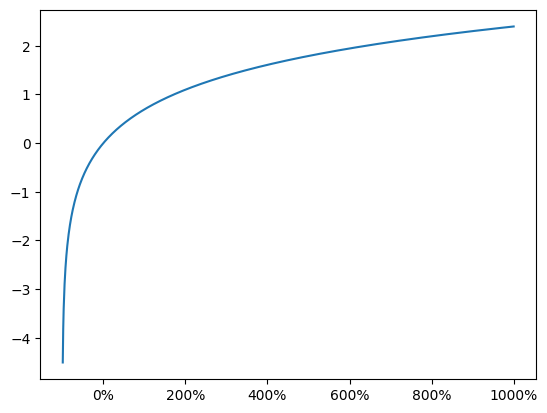

In [ ]:
# simple proofit rate = x, logged profit rate = y
x = np.linspace(-1, 10, 1000)
plt.plot(x * 100, simple_to_log(x))
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
plt.show()

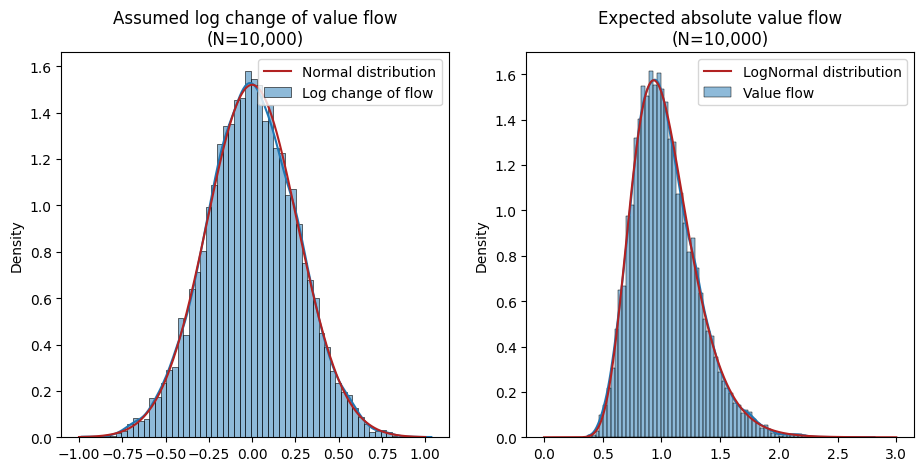

In [ ]:
# relation between log normal distribution and normal distribution
from scipy.stats import norm, lognorm

mean = 0
standard_deviation = simple_to_log(0.3)
normal_dist = norm(loc=mean, scale=standard_deviation)
lognormal_dist = lognorm(s=standard_deviation, scale=np.exp(mean))

# normal sampling
samples_norm = np.random.normal(loc=mean, scale=standard_deviation, size=10000)

x_normal = np.linspace(-1, 1, 10000)
x_lognormal = np.linspace(0, 3, 10000)

fig, axs = plt.subplots(ncols=2, figsize=(11,5))

sns.histplot(samples_norm, kde=True, stat='density', label='Log change of flow', ax=axs[0])
axs[0].set_title('Assumed log change of value flow\n(N=10,000)')
axs[0].plot(x_normal, normal_dist.pdf(x_normal), color='firebrick', label='Normal distribution')
axs[0].legend(loc='upper right')

sns.histplot(np.exp(samples_norm), kde=True, stat='density', label='Value flow', ax=axs[1])
axs[1].set_title('Expected absolute value flow\n(N=10,000)')
axs[1].plot(x_lognormal, lognormal_dist.pdf(x_lognormal), color='firebrick', label='LogNormal distribution')
axs[1].legend(loc='upper right')

plt.show()

#### Flow Simulation

In [ ]:
# X ~ N(mu, sigma)
# Whatever variance is, expectation through MC simulation is the same.
# give a drift to have positive variance

# assumption initialization to base case
apply_assumption(0)

# Standard deviation of expected rate of change
std_dev_map = {
    'Organic': simple_to_log(0.2),
    'Paid': simple_to_log(0.5),
    'Social': simple_to_log(2),
    'Retarget': simple_to_log(0.3),
}

link_df['std_dev'] = link_df['source_category'].map(std_dev_map)

In [ ]:
"""
# Monte Carlo simulation

[개요]
- 모든 노드가 N(0,1)을 따른다고 했던 첫 시뮬레이션 시도가 실패했던 이유? 모든 노드가 independent 하다면 각 노드가 같은 값으로 수렴해 전체 expectation에는 변화가 없다
- but 현실에서는 당연히 path dependency가 있다: static snapshot이자 aggregated 상태인 given dataset에서 구분해낼 수 없었을 뿐
- 각 노드가 N(0,1)을 따르는 동시에 + 앞 단계의 outflow에 의존적이라는 2가지 가정을 도입함으로써 개별 path의 score를 계산할 수 있게 되었다
- 결과적으로, first touch에서 시작되는 link를 제외하면 주어진 value는 무시되고 다시 계산된 것 (단, local_ratio 형태로 비율정보만 반영)

[시뮬레이션 유형]
1. 특정 path만 살려둔 채로 시뮬레이션
ex) 다음 4개의 개별 path에 어떻게 다른 Score를 배분할 것인가?
    Influencer5 > Youtuber1 > NoConversion
    TV_Show > Youtuber1 > NoConversion
    CompanyWebpage > Youtuber1 > NoConversion
    SNS1 > Youtuber1 > NoConversion

2. drop out 대상을 바꿔가면서 시뮬레이션: 전체 value의 변화를 가지고 maximization에 도움이 되는 노드 판단할 때 사용
이때 다수의 레이어로 구성된 네트워크에서 앞쪽이 drop-out 되면 뒤쪽 경우의 수를 모두 계산할 필요 없음
필요한 연산 횟수는 2^n이 아니라 n+1 (n = 레이어 수)
"""
#To reduce computational cost, we used a dropout method that reduces the number of calculations from 2^n to n+1.
def flow_simulation(M=1, input_field='value', output_field='value_new', assumption=0, selected_path=[], hide_unselected=False, drop_out=[], verbose=True):
    """
    M: Number of iteration
    input_field: starting point of simulation (value or expected_value)
    ourtput_field: result type of simulation (value_new or conversion_value)
    selected_path: keep the designated nodes only
    hide_unselected: hide unselected nodes (even if links with in/outflow exist)
    drop_out: mute specified nodes (zero value outflow)
    verbose: show loop status, processing time
    """
    # conversion price mapping
    conversion = pd.DataFrame(conversion_price).iloc[assumption]
    start_time = time.time()

    # Before looping, prepare link data in advance to avoid iterration
    links_list_ = []
    for k in range(7):
        # extract links lies in the specific depth
        links_ = link_df[link_df['path_index'] == k].copy()
        links_[['z_score', 'value_new']] = None
        if selected_path:
            links_ = links_[(links_['source'].isin(selected_path))]
        if k == 0:
            links_['value_new'] = links_[input_field]

        links_list_.append(links_)

    for m in range(M):

        prev_links_ = pd.DataFrame()
        for k in range(7):
            links_ = links_list_[k].copy()

            # update values changed by previous depth
            if k != 0:
                prev_links_['value_from_prev'] = prev_links_['value_new'] * prev_links_['local_ratio_out']
                prev_outflow_ = prev_links_[['target', 'value_from_prev']].groupby(by='target').sum().reset_index()
                links_['value_new'] = links_['source'].map(prev_outflow_.set_index('target')['value_from_prev']) * links_['local_ratio_out']

            # elimiinate drop-out node inflow
            links_.loc[links_['source'].isin(drop_out), 'value_new'] = 0

            # generate a normal sample to estimate log growth rate of this period
            links_['z_score'] = links_['std_dev'].apply(lambda x: np.random.normal(0, x, size=1).mean())
            links_['log_change'] = links_['z_score'] * links_['std_dev'] + 0
            links_['value_new'] = links_['value_new'] * np.exp(links_['log_change'])
            links_['conversion_value'] = links_['value_new'] * links_['conversion_price']

            # do not show the nodes not in selected_path, except the ones directly linked to Conversions
            if selected_path and hide_unselected:
                links_.loc[(~links_['target'].isin(selected_path)) & (links_['target_type'] != 'Conversion'), 'value_new'] = 0

            # prepare the prior-depth link data in the next iteration
            prev_links_ = pd.concat([prev_links_, links_], axis=0)

            # accumulate previous works throughout all depths
            output_ = links_[output_field].copy().fillna(links_['value_new'])
            if k == 0:
                all_paths_ = pd.concat([output_], axis=0)
            else:
                all_paths_ = pd.concat([all_paths_, output_], axis=0)

        # accumulate previous works throughout all simulation loops
        if m == 0:
            all_batch_ = pd.concat([all_paths_], axis=1)
        else:
            all_batch_ = pd.concat([all_batch_, all_paths_], axis=1)

        if verbose and (m % 1000 == 0):
                print(f'Processing {m}/{M}...')

    end_time = time.time()
    if verbose:
        print(f'Time taken: {end_time - start_time} seconds')

    result = all_batch_.sort_index()
    result.columns = range(M)
    result['value'] = result.mean(axis=1)
    col_restore = ['source', 'target', 'source_idx', 'target_idx', 'target_category']
    result = result.join(link_df[col_restore], how='left')

    return result

# including NoConverion
simulated_1 = flow_simulation(M=1,
    # input_field='value', output_field='conversion_value',
    # selected_path=['SNS2', 'TV_Show', 'Youtuber1', 'Youtuber2', 'Search1', 'Retargeting1'],
    # hide_unselected=True,
    # drop_out=['Retargeting1']
)
draw_sankey(simulated_1, '[Test] Sankey diagram', 800, 500)

Processing 0/1...
Time taken: 0.05094742774963379 seconds


In [ ]:
# Execute simulation with input: value
simulated_1 = flow_simulation(M=1)
simulated_10 = flow_simulation(M=10)
simulated_100 = flow_simulation(M=100)
simulated_1000 = flow_simulation(M=1000)
simulated_10000 = flow_simulation(M=10000) # 713 secs

Processing 0/1...
Time taken: 0.056552886962890625 seconds
Processing 0/10...
Time taken: 0.48822569847106934 seconds
Processing 0/100...
Time taken: 4.755744934082031 seconds
Processing 0/1000...
Time taken: 57.90387320518494 seconds
Processing 0/10000...
Processing 1000/10000...
Processing 2000/10000...
Processing 3000/10000...


In [ ]:
simulated_10000

### Resampling results

#### Visualize all value flows

In [ ]:
# Sankey diagram
width = 600
height = 500
draw_sankey(simulated_1, 'Sankey diagram (4-1): MC simulation (iteration = 1)', width, height)
draw_sankey(simulated_10, 'Sankey diagram (4-2): MC simulation (iteration = 10)', width, height)
draw_sankey(simulated_100, 'Sankey diagram (4-3): MC simulation (iteration = 100)', width, height)
draw_sankey(simulated_1000, 'Sankey diagram (4-4): MC simulation (iteration = 1,000)', width, height)
draw_sankey(simulated_10000, 'Sankey diagram (4-5): MC simulation (iteration = 10,000)', width, height)

#### Distribution of flow led to conversion

In [ ]:
# Conversion에 해당하는 link data만
# input: value 기준
def drop_non_conversion(simulated):
    temp_ = simulated.drop(simulated[simulated['target_category'] != 'Conversion'].index)
    temp_ = temp_.drop(simulated[simulated['target'] == 'NoConversion'].index)
    return temp_

simulated_conv_1 = drop_non_conversion(simulated_1)
simulated_conv_10 = drop_non_conversion(simulated_10)
simulated_conv_100 = drop_non_conversion(simulated_100)
simulated_conv_1000 = drop_non_conversion(simulated_1000)
simulated_conv_10000 = drop_non_conversion(simulated_10000)

# 차트 생성용 데이터
x = range(10000)
y_10 = simulated_conv_10.sum(axis=0)[:10].astype(float)
y_100 = simulated_conv_100.sum(axis=0)[:100].astype(float)
y_1000 = simulated_conv_1000.sum(axis=0)[:1000].astype(float)
y_10000 = simulated_conv_10000.sum(axis=0)[:10000].astype(float)

# 상위 percentile 기준 outlier 확인
y_data = pd.DataFrame(y_10000, columns=['raw'])
y_data['rank'] = y_data['raw'].rank(pct=True)
y_data.sort_values(by='raw', ascending=False, inplace=True)

cutoff = y_data[y_data['rank'] > 0.999]
y_10000.describe()

count   10,000.00
mean     2,759.16
std      1,881.61
min        796.58
25%      1,802.74
50%      2,326.08
75%      3,160.75
max     78,821.32
dtype: float64

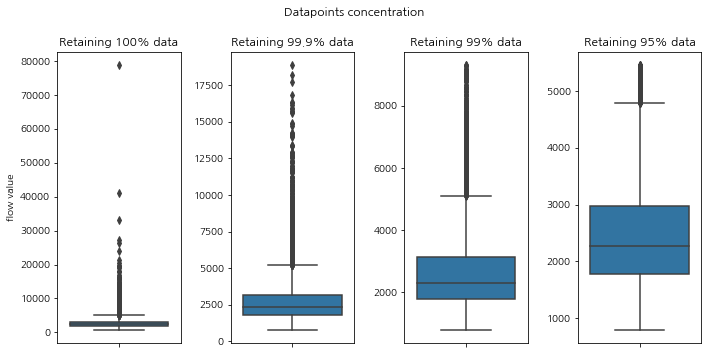

In [ ]:
# 데이터 분포
fig, axs = plt.subplots(ncols=4, figsize=(10,5))

plt.suptitle('Datapoints concentration')

sns.boxplot(y=y_data['raw'], ax=axs[0])
sns.boxplot(y=y_data[y_data['rank'] < 0.999]['raw'], ax=axs[1])
sns.boxplot(y=y_data[y_data['rank'] < 0.99]['raw'], ax=axs[2])
sns.boxplot(y=y_data[y_data['rank'] < 0.95]['raw'], ax=axs[3])

axs[0].set_title('Retaining 100% data')
axs[1].set_title('Retaining 99.9% data')
axs[2].set_title('Retaining 99% data')
axs[3].set_title('Retaining 95% data')

axs[0].set_ylabel('flow value')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[3].set_ylabel('')

sns.set_theme(style='whitegrid')

plt.tight_layout()
plt.show()

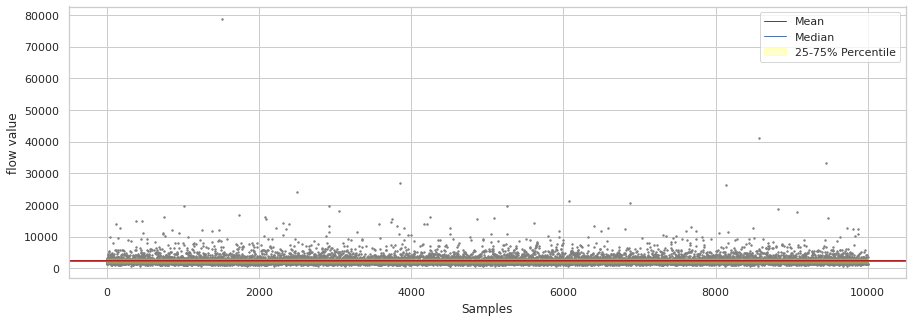

In [ ]:
plt.figure(figsize=(15,5))

plt.scatter(x, y_10000, s=2, color='grey')
# plt.fill_between(x, np.percentile(y_10000, 5), np.percentile(y_10000, 95), color='yellow', alpha=0.2, label='5-95% Percentile')
plt.fill_between(x, np.percentile(y_10000, 25), np.percentile(y_10000, 75), color='yellow', alpha=0.2, label='25-75% Percentile')
plt.axhline(y_10000.mean(), label='Mean', lw=1, color='firebrick')
plt.axhline(y_10000.median(), label='Median', lw=1)
# plt.axhline(np.percentile(y_10000, 99.9), label='99.9% percentile', lw=1, color='firebrick')
# plt.axhline(np.percentile(y_10000, 99), label='99% percentile', lw=1, color='green')

plt.legend()
# plt.yscale('log')
plt.xlabel('Samples')
plt.ylabel('flow value')
plt.show()

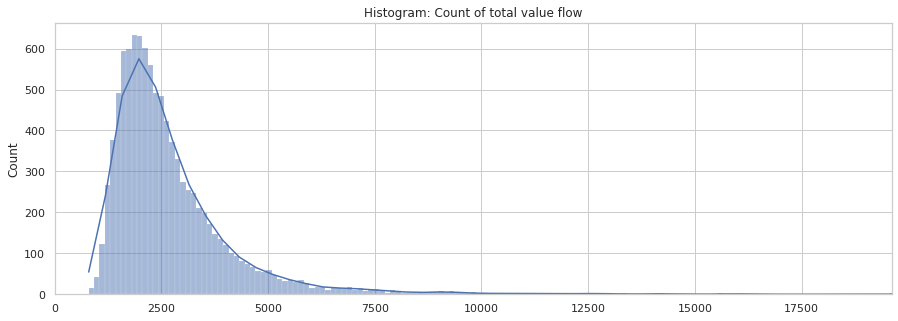

In [ ]:
plt.figure(figsize=(15,5))
sns.histplot(y_10000, kde=True)
plt.xlim(0, cutoff['raw'].min())
plt.title('Histogram: Count of total value flow')
plt.show()

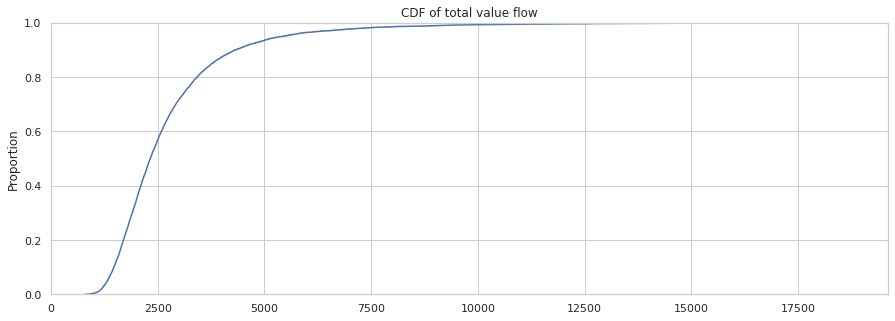

In [ ]:
plt.figure(figsize=(15,5))
sns.ecdfplot(y_10000)
plt.xlim(0, cutoff['raw'].min())
plt.title('CDF of total value flow')
plt.show()

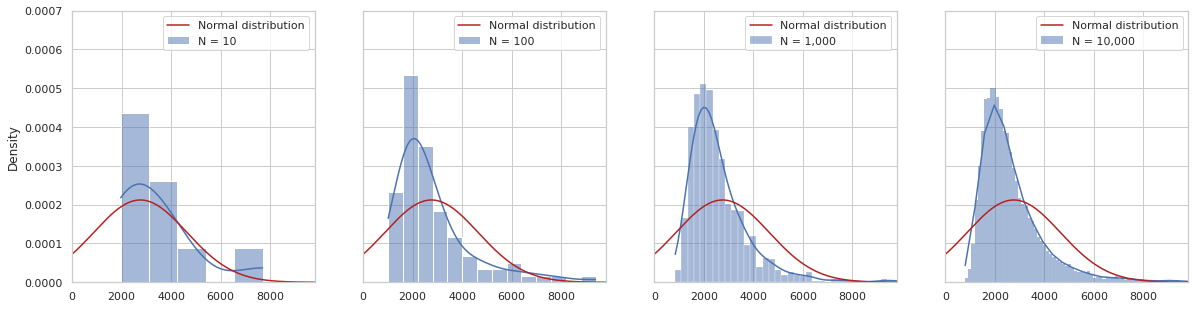

In [ ]:
from scipy.stats import norm

fig, axs = plt.subplots(ncols=4, figsize=(20, 5), sharey=True)

sns.histplot(y_10, kde=True, stat='density', label='N = 10', ax=axs[0])
sns.histplot(y_100, kde=True, stat='density', label='N = 100', ax=axs[1])
sns.histplot(y_1000, kde=True, stat='density', label='N = 1,000', ax=axs[2])
sns.histplot(y_10000, kde=True, stat='density', label='N = 10,000', ax=axs[3])

norm_dist = norm(loc=y_10000.mean(), scale=y_10000.std())
x = np.linspace(0, cutoff['raw'].min(), 10000)

for ax in axs:
    ax.plot(x, norm_dist.pdf(x), color='firebrick', label='Normal distribution')
    ax.legend(loc='upper right')
    ax.set_xlim(0, cutoff['raw'].min()/2)
    ax.set_ylim(top=0.0007)

plt.show()

### Solutions (Overview)

#### Path-Score calculation (for Shapley value)

In [ ]:
"""
샤플리 밸류를 계산하기 위한 path별 score 계산
- 시뮬레이션을 통해 특정 path에서 conversion에 도달하는 flow value의 평균 계산
- apply_assumption() 함수를 통해 budget, cost로 조정된 expected value로 환산 가능
- conversion value: 시뮬레이션에서 구해진 last touch > conversion link의 value_new 값을 이용해 계산

연산이 오래 걸리는 이유: 모든 path 수 * 시뮬레이션 횟수
"""
# 시뮬레이션 결과에서 conversion으로 도달한 value만 합산
def simulate_path(x, M, input_field, output_field, channel_to_fire=[]):
    simulation_ = flow_simulation(
        M=M, input_field=input_field, output_field=output_field, selected_path=x.split('+'), hide_unselected=True, drop_out=channel_to_fire, verbose=False
    )
    return simulation_[simulation_['target_category'] == 'Conversion']['value'].sum() # return되는 결과 열 이름은 value로 고정

# path별 시뮬레이션 함수
def recalculate_path_score(all_paths, M, input_field, output_field, channel_to_fire=[]):
    for m in M:
        start_time = time.time()
        all_paths['value_' + str(m)] = all_paths['source_all_ordered'].apply(
            lambda x: simulate_path(x, M=m, input_field=input_field, output_field=output_field, channel_to_fire=channel_to_fire)
        )
        end_time = time.time() # M=1, appx. 12 secs
        print(f'Time taken: {end_time - start_time} seconds: M={m}')

    return all_paths

# flow가 주어져 있는 모든 path 리스팅
# direct conviersion이 존재하는 Coalition - Conversion value 페어 수는 총 415개
all_paths = paths_split.copy()[['source', 'target', 'source_all_ordered']]
# 중복 path: last touch가 여러 conversion으로 연결되는 경우 발생
# flow_simulation은 모든 conversion으로의 link가 살아있는 값이 반환: 중복 시뮬레이션 불필요
# 제거 후 120개로 감소
all_paths.drop_duplicates('source_all_ordered', inplace=True)

# Expected value 재계산 (link_df, node_df 업데이트)
apply_assumption(0)

In [ ]:
# path별 시뮬레이션 진행

# conversion value 기준: 샤플리밸류 계산기준
all_paths_base = recalculate_path_score(
    all_paths, M=[10, 100, 500, 1000], # 1000 = 140 mins
    input_field='expected_value', output_field='conversion_value'
)

Time taken: 85.76293706893921 seconds: M=10
Time taken: 835.8005583286285 seconds: M=100
Time taken: 4159.68621301651 seconds: M=500
Time taken: 8322.94493985176 seconds: M=1000


In [ ]:
shapley_input = all_paths_base.loc[:, ~all_paths_base.columns.isin(['source', 'target'])].set_index('source_all_ordered')
shapley_input

,value_10,value_100,value_500,value_1000
source_all_ordered,,,,
Youtuber1+TV_Show,0.00,0.00,0.00,0.00
Youtuber1+SNS1,0.00,0.00,0.00,0.00
Youtuber1+CompanyWebpage,0.00,0.00,0.00,0.00
Youtuber1+Influencer5,0.00,0.00,0.00,0.00
Email1+Search1+Youtuber5+Youtuber1+TV_Show,440.77,623.03,568.70,604.46
...,...,...,...,...
Search1+Youtuber2+Youtuber1+Influencer5,"5,738.26","8,085.06","9,163.14","6,500.09"
Search1+Youtuber2+Youtuber3,546.95,"3,220.45","1,506.60","1,978.31"
Search1+Youtuber2+Email3+Email4,"1,107.66",195.41,301.40,236.50


#### Shapley value calculation

In [ ]:
# Subgame approach With simulated data
shapley_value_10 = calculate_shapley_by_subgame(shapley_input['value_10'].to_frame())
shapley_value_100 = calculate_shapley_by_subgame(shapley_input['value_100'].to_frame())
shapley_value_500 = calculate_shapley_by_subgame(shapley_input['value_500'].to_frame())
shapley_value_1000 = calculate_shapley_by_subgame(shapley_input['value_1000'].to_frame())

shapley_value_1000.sort_values('shapley_value', ascending=False).head()

,shapley_value
Retargeting1,"113,056.70"
Retargeting2,"63,757.23"
Influencer7,"57,011.72"
Search1,"54,021.59"
Blogger2,"51,772.70"


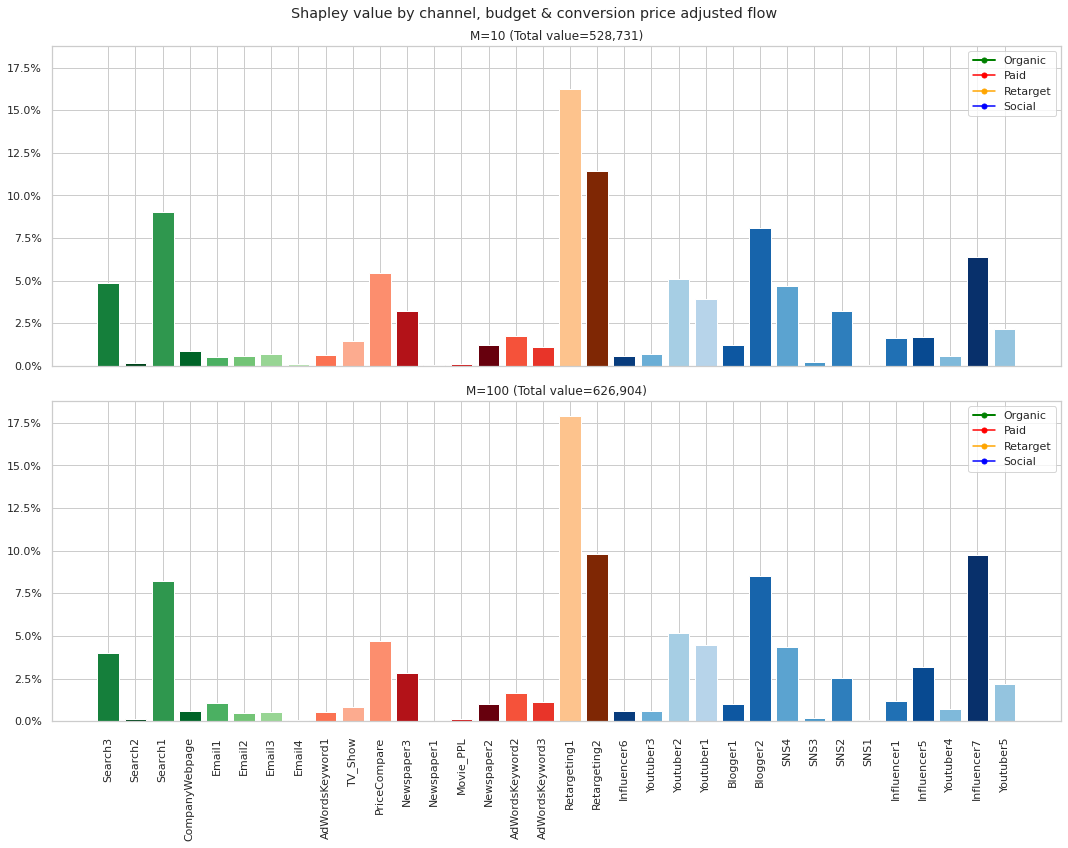

In [ ]:
# Plotting
import matplotlib.ticker as mtick

fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(15,12))

shapley_result = node_df.copy()
shapley_result['color'] = node_colors_tuple

shapley_result_10 = shapley_value_10.join(shapley_result.set_index('name'), how='left')
total_sum_10 = shapley_result_10['shapley_value'].sum()
shapley_result_10['shapley_value_percent'] = shapley_result_10['shapley_value'] / total_sum_10 * 100
shapley_result_10.sort_values('category', inplace=True)

shapley_result_100 = shapley_value_100.join(shapley_result.set_index('name'), how='left')
total_sum_100 = shapley_result_100['shapley_value'].sum()
shapley_result_100['shapley_value_percent'] = shapley_result_100['shapley_value'] / total_sum_100 * 100
shapley_result_100.sort_values('category', inplace=True)

# shapley_result_500 = shapley_value_500.join(shapley_result.set_index('name'), how='left')
# total_sum_500 = shapley_result_500['shapley_value'].sum()
# shapley_result_500['shapley_value_percent'] = shapley_result_500['shapley_value'] / total_sum_500 * 100
# shapley_result_500.sort_values('category', inplace=True)

# shapley_result_1000 = shapley_value_1000.join(shapley_result.set_index('name'), how='left')
# total_sum_1000 = shapley_result_1000['shapley_value'].sum()
# shapley_result_1000['shapley_value_percent'] = shapley_result_1000['shapley_value'] / total_sum_1000 * 100
# shapley_result_1000.sort_values('category', inplace=True)

fig.suptitle('Shapley value by channel, budget & conversion price adjusted flow')

# Grand coalition의 v(S)와 합계가 일치해야 하나 데이터 없으므로 정합성 확인 불가
axs[0].bar(shapley_result_10.index, shapley_result_10['shapley_value_percent'], color=shapley_result_10['color'])
axs[0].set_title(f"M=10 (Total value={total_sum_10:,.0f})")

axs[1].bar(shapley_result_10.index, shapley_result_100['shapley_value_percent'], color=shapley_result_100['color'])
axs[1].set_title(f"M=100 (Total value={total_sum_100:,.0f})")

# axs[2].bar(shapley_result_10.index, shapley_result_500['shapley_value_percent'], color=shapley_result_500['color'])
# axs[2].set_title(f"M=500 (Total value={total_sum_500:,.0f})")

# axs[3].bar(shapley_result_10.index, shapley_result_1000['shapley_value_percent'], color=shapley_result_1000['color'])
# axs[3].set_title(f"M=1000 (Total value={total_sum_1000:,.0f})")
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter())
axs[1].tick_params(axis='x', labelrotation=90, size=12)

# Composing custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', markersize=5, color='green', lw=2, label='Organic'),
    Line2D([0], [0], marker='o', markersize=5, color='red', label='Paid'),
    Line2D([0], [0], marker='o', markersize=5, color='orange', label='Retarget'),
    Line2D([0], [0], marker='o', markersize=5, color='blue', label='Social'),
]
axs[0].legend(handles=legend_elements, loc='upper right')
axs[1].legend(handles=legend_elements, loc='upper right')
# axs[2].legend(handles=legend_elements, loc='upper right')
# axs[3].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# 중간 계산결과 보존 장소
path_reserve = {}

In [ ]:
def recalcuate_shapley(assumption, M, input_field, output_field, channel_to_fire=[]):
    all_paths = paths_split.copy()[['source', 'target', 'source_all_ordered']]
    all_paths.drop_duplicates('source_all_ordered', inplace=True)

    apply_assumption(assumption)
    all_paths = recalculate_path_score(all_paths, M=[M], input_field=input_field, output_field=output_field, channel_to_fire=channel_to_fire)
    path_reserve[assumption] = all_paths.copy() # keep intermediate calculation result

    # 샤플리 밸류 input data 준비
    shapley_input = all_paths.loc[:, ~all_paths.columns.isin(['source', 'target'])].set_index('source_all_ordered')
    shapley_value = calculate_shapley_by_subgame(shapley_input)

    shapley_value['shapley_value_percent'] = shapley_value['shapley_value'] / shapley_value['shapley_value'].sum()
    shapley_value['new_bugdet_assignment'] = 3400 * shapley_value['shapley_value_percent']

    return shapley_value.sort_values('shapley_value', ascending=False)

In [ ]:
M = 1000 # 1000 = 138 mins
# shapely_value_A3 = recalcuate_shapley(3, M, input_field='expected_value', output_field='conversion_value')

shapely_value_A4 = recalcuate_shapley(4, M, input_field='expected_value', output_field='conversion_value')
shapely_value_A6 = recalcuate_shapley(6, M, input_field='expected_value', output_field='conversion_value')
shapely_value_A7 = recalcuate_shapley(7, M, input_field='expected_value', output_field='conversion_value')
shapely_value_A8 = recalcuate_shapley(8, M, input_field='expected_value', output_field='conversion_value')
shapely_value_A9 = recalcuate_shapley(9, M, input_field='expected_value', output_field='conversion_value')
shapely_value_A10 = recalcuate_shapley(10, M, input_field='expected_value', output_field='conversion_value')
shapely_value_A11 = recalcuate_shapley(11, M, input_field='expected_value', output_field='conversion_value')
shapely_value_A12 = recalcuate_shapley(12, M, input_field='expected_value', output_field='conversion_value')
shapely_value_A13 = recalcuate_shapley(13, M, input_field='expected_value', output_field='conversion_value')

Time taken: 8370.825271606445 seconds: M=1000
Time taken: 8310.465049028397 seconds: M=1000
Time taken: 8290.561272382736 seconds: M=1000
Time taken: 8257.575634241104 seconds: M=1000
Time taken: 8673.254900217056 seconds: M=1000
Time taken: 8374.128312587738 seconds: M=1000
Time taken: 8352.465869903564 seconds: M=1000
Time taken: 8465.79020690918 seconds: M=1000
Time taken: 8320.759938001633 seconds: M=1000


### Solutions (Questions)

#### Resampling

In [ ]:
M = 10000 # 11 mins
apply_assumption(0)
simulated_A0_value = flow_simulation(M=M, input_field='expected_value', output_field='value_new')
simulated_A0 = flow_simulation(M=M, input_field='expected_value', output_field='conversion_value')
apply_assumption(1)
simulated_A1_value = flow_simulation(M=M, input_field='expected_value', output_field='value_new')
simulated_A1 = flow_simulation(M=M, input_field='expected_value', output_field='conversion_value')
apply_assumption(2)
simulated_A2_value = flow_simulation(M=M, input_field='expected_value', output_field='value_new')
simulated_A2 = flow_simulation(M=M, input_field='expected_value', output_field='conversion_value')
apply_assumption(3)
simulated_A3_value = flow_simulation(M=M, input_field='expected_value', output_field='value_new')
simulated_A3 = flow_simulation(M=M, input_field='expected_value', output_field='conversion_value')
apply_assumption(4)
simulated_A4_value = flow_simulation(M=M, input_field='expected_value', output_field='value_new')
simulated_A4 = flow_simulation(M=M, input_field='expected_value', output_field='conversion_value')
apply_assumption(5)
simulated_A5 = flow_simulation(M=M, input_field='expected_value', output_field='conversion_value')
apply_assumption(6)
simulated_A6 = flow_simulation(M=M, input_field='expected_value', output_field='conversion_value')
apply_assumption(7)
simulated_A7 = flow_simulation(M=M, input_field='expected_value', output_field='conversion_value')
apply_assumption(8)
simulated_A8 = flow_simulation(M=M, input_field='expected_value', output_field='conversion_value')
apply_assumption(9)
simulated_A9 = flow_simulation(M=M, input_field='expected_value', output_field='conversion_value')
apply_assumption(10)
simulated_A10_value = flow_simulation(M=M, input_field='expected_value', output_field='value_new')
simulated_A10 = flow_simulation(M=M, input_field='expected_value', output_field='conversion_value')
apply_assumption(11)
simulated_A11_value = flow_simulation(M=M, input_field='expected_value', output_field='value_new')
simulated_A11 = flow_simulation(M=M, input_field='expected_value', output_field='conversion_value')
apply_assumption(12)
simulated_A12 = flow_simulation(M=M, input_field='expected_value', output_field='conversion_value')
apply_assumption(13)
simulated_A13 = flow_simulation(M=M, input_field='expected_value', output_field='conversion_value')

Processing 0/10000...
Processing 1000/10000...
Processing 2000/10000...
Processing 3000/10000...
Processing 4000/10000...
Processing 5000/10000...
Processing 6000/10000...
Processing 7000/10000...
Processing 8000/10000...
Processing 9000/10000...
Time taken: 673.8782074451447 seconds
Processing 0/10000...
Processing 1000/10000...
Processing 2000/10000...
Processing 3000/10000...
Processing 4000/10000...
Processing 5000/10000...
Processing 6000/10000...
Processing 7000/10000...
Processing 8000/10000...
Processing 9000/10000...
Time taken: 678.6248641014099 seconds
Processing 0/10000...
Processing 1000/10000...
Processing 2000/10000...
Processing 3000/10000...
Processing 4000/10000...
Processing 5000/10000...
Processing 6000/10000...
Processing 7000/10000...
Processing 8000/10000...
Processing 9000/10000...
Time taken: 674.7952253818512 seconds
Processing 0/10000...
Processing 1000/10000...
Processing 2000/10000...
Processing 3000/10000...
Processing 4000/10000...
Processing 5000/10000..

#### Q2

In [ ]:
# Importance measured by MTA model = Shapley value

# use base scenario
shapley_value = shapley_value_1000.copy()
shapley_value['shapley_value_percent'] = shapley_value['shapley_value'] / shapley_value['shapley_value'].sum()
shapley_value['new_bugdet_assignment'] = 3400 * shapley_value['shapley_value_percent'] / 100
shapley_value.head()

,shapley_value,shapley_value_percent,new_bugdet_assignment
AdWordsKeyword1,"3,001.85",0.00,0.16
AdWordsKeyword2,"9,114.46",0.01,0.50
AdWordsKeyword3,"6,112.62",0.01,0.34
Blogger1,"6,667.29",0.01,0.37
Blogger2,"51,772.70",0.08,2.84


In [ ]:
"""
시나리오 별 가정 선택
https://docs.google.com/spreadsheets/d/16hTAc7Pn0I6piBQ4Xpbj35aZWXxn8sPycwKnFEVeRlw/edit#gid=107363863

index	문제	시나리오 내용
0	Base	기본값
1	Q2-1	모든 광고단가 동일
2	Q2-2	소셜미디어 광고비 50%
3	Q2-3	이커머스 = 신문 * 3
4	Q4-1	모든 광고단가 동일
5	Q4-2	소셜미디어 광고비 50%
6	Q4-3	이커머스 = 신문 * 3
7	Q5	채널별 가격배수 가정
8	Q6	리타게팅 = 신문 * 3
9	Q7	상품10,11 가격 * 2
10	Q8	상품10,11 구매취소율 40%
11	Q10	채널 재선택
12	Bonus	보너스
"""
# Compare flow value to conversion

# Simulate values reach conversion
# (1) with existing budget assingnment
apply_assumption(0)
simulated_Q2_A0 = flow_simulation(M=1000, input_field='expected_value', output_field='value_new')

# (2) with new budget assingnment: all channel cost is the same
apply_assumption(2)
simulated_Q2_A2 = flow_simulation(M=1000, input_field='expected_value', output_field='value_new')

In [ ]:
# Draw Sankey with new budget assignment
# draw_sankey(simulated_Q2_A0, '[Q2-1] With existing budget assignment', 800, 500)
# draw_sankey(simulated_Q2_A2, '[Q2-2] With new budget assignment', 800, 500)
draw_sankey(simulated_A0_value, '[Q2-1] With existing budget assignment', 800, 500)
draw_sankey(simulated_A2_value, '[Q2-2] With new budget assignment', 800, 500)

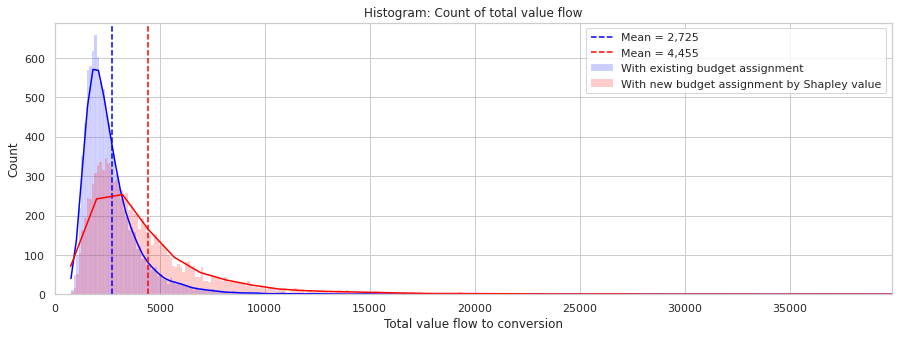

In [ ]:
# Compare sum of total flow
# simulated_conv_Q2_A0 = drop_non_conversion(simulated_Q2_A0)
# simulated_conv_Q2_A2 = drop_non_conversion(simulated_Q2_A2)
simulated_conv_Q2_A0 = drop_non_conversion(simulated_A0_value)
simulated_conv_Q2_A2 = drop_non_conversion(simulated_A2_value)

# 차트 생성용 데이터
x = range(10000)
y_0 = simulated_conv_Q2_A0.sum(axis=0)[:10000].astype(float)
y_1 = simulated_conv_Q2_A2.sum(axis=0)[:10000].astype(float)

# x축 범위를 제한
y_data = pd.DataFrame(y_1, columns=['raw'])
y_data['rank'] = y_data['raw'].rank(pct=True)
y_data.sort_values(by='raw', ascending=False, inplace=True)
cutoff = y_data[y_data['rank'] > 0.999]

plt.figure(figsize=(15,5))
bins = np.histogram_bin_edges(y_0, bins='auto')
sns.histplot(y_0, color='blue', bins=bins, alpha=0.2, kde=True, label='With existing budget assignment')
plt.axvline(y_0.mean(), color='blue', linestyle='--', label=f'Mean = {y_0.mean():,.0f}')
sns.histplot(y_1, color='red', bins=bins, alpha=0.2, kde=True, label='With new budget assignment by Shapley value')
plt.axvline(y_1.mean(), color='red', linestyle='--', label=f'Mean = {y_1.mean():,.0f}')

plt.xlim(0, cutoff['raw'].min())
plt.xlabel('Total value flow to conversion')
plt.title('Histogram: Count of total value flow')
plt.legend()
plt.show()

In [ ]:
# Three diffrent scenarios with channel cost

# Simulate values reach conversion
# (2) with new budget assingnment: Social media cost = 50% other channels
apply_assumption(3)
simulated_Q2_A3 = flow_simulation(M=1000, input_field='expected_value', output_field='value_new')

# (3) with new budget assingnment: E-commerce = 3 times of newspaper
apply_assumption(4)
simulated_Q2_A4 = flow_simulation(M=1000, input_field='expected_value', output_field='value_new')

Processing 0/1000...
Time taken: 72.53552174568176 seconds
Processing 0/1000...
Time taken: 71.17075610160828 seconds


In [ ]:
# Compare sum of total flow
# simulated_conv_Q2_A3 = drop_non_conversion(simulated_Q2_A3)
# simulated_conv_Q2_A4 = drop_non_conversion(simulated_Q2_A4)
simulated_conv_Q2_A3 = drop_non_conversion(simulated_A3_value)
simulated_conv_Q2_A4 = drop_non_conversion(simulated_A4_value)

# 차트 생성용 데이터
y_2 = simulated_conv_Q2_A3.sum(axis=0)[:10000].astype(float)
y_3 = simulated_conv_Q2_A4.sum(axis=0)[:10000].astype(float)

plt.figure(figsize=(15,5))
bins = np.histogram_bin_edges(y_1, bins='auto')
sns.histplot(y_1, color='red', bins=bins, alpha=0.2, kde=True, label='With new budget assignment: Cost scenario #1')
plt.axvline(y_1.mean(), color='red', linestyle='--', label=f'Mean = {y_1.mean():,.0f}')
sns.histplot(y_2, color='green', bins=bins, alpha=0.2, kde=True, label='With new budget assignment: Cost scenario #2')
plt.axvline(y_2.mean(), color='green', linestyle='--', label=f'Mean = {y_2.mean():,.0f}')
sns.histplot(y_3, color='purple', bins=bins, alpha=0.2, kde=True, label='With new budget assignment: Cost scenario #3')
plt.axvline(y_3.mean(), color='purple', linestyle='--', label=f'Mean = {y_3.mean():,.0f}')

plt.xlim(0, cutoff['raw'].min())
plt.xlabel('Total value flow to conversion')
plt.title('Histogram: Count of total value flow')
plt.legend()
plt.show()

#### Q3

In [ ]:
# Simulate values reach conversion
# (1) with new budget assingnment: all channel cost is the same
apply_assumption(2)
simulated_Q3_A2 = flow_simulation(M=1000, input_field='expected_value', output_field='conversion_value')

# (2) with new budget assingnment: Social media cost = 50% other channels
apply_assumption(3)
simulated_Q3_A3 = flow_simulation(M=1000, input_field='expected_value', output_field='conversion_value')

# (3) with new budget assingnment: E-commerce = 3 times of newspaper
apply_assumption(4)
simulated_Q3_A4 = flow_simulation(M=1000, input_field='expected_value', output_field='conversion_value')

Processing 0/1000...
Time taken: 71.59537506103516 seconds
Processing 0/1000...
Time taken: 73.3155586719513 seconds
Processing 0/1000...
Time taken: 70.70511412620544 seconds


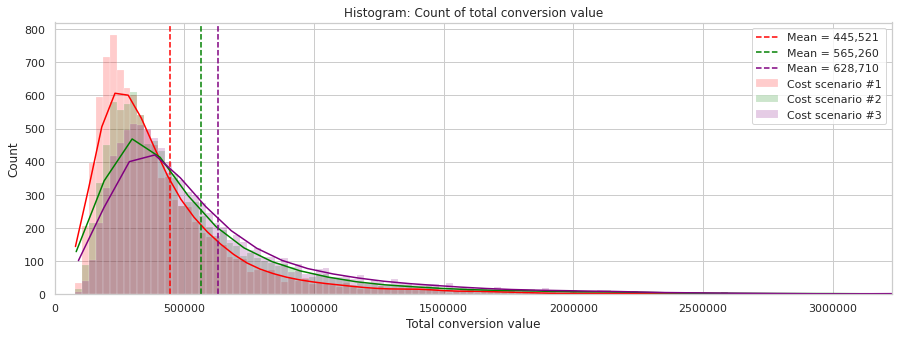

In [ ]:
# Compare sum of total flow
# simulated_conv_Q3_A2 = drop_non_conversion(simulated_Q3_A2)
# simulated_conv_Q3_A3 = drop_non_conversion(simulated_Q3_A3)
# simulated_conv_Q3_A4 = drop_non_conversion(simulated_Q3_A4)
simulated_conv_Q3_A2 = drop_non_conversion(simulated_A2)
simulated_conv_Q3_A3 = drop_non_conversion(simulated_A3)
simulated_conv_Q3_A4 = drop_non_conversion(simulated_A4)

# 차트 생성용 데이터
y_1 = simulated_conv_Q3_A2.sum(axis=0)[:10000].astype(float)
y_2 = simulated_conv_Q3_A3.sum(axis=0)[:10000].astype(float)
y_3 = simulated_conv_Q3_A4.sum(axis=0)[:10000].astype(float)

# x축 범위를 제한
y_data = pd.DataFrame(y_1, columns=['raw'])
y_data['rank'] = y_data['raw'].rank(pct=True)
y_data.sort_values(by='raw', ascending=False, inplace=True)
cutoff = y_data[y_data['rank'] > 0.997]

plt.figure(figsize=(15,5))
bins = np.histogram_bin_edges(y_1, bins='auto')
sns.histplot(y_1, color='red', bins=bins, alpha=0.2, kde=True, label='Cost scenario #1')
plt.axvline(y_1.mean(), color='red', linestyle='--', label=f'Mean = {y_1.mean():,.0f}')
sns.histplot(y_2, color='green', bins=bins, alpha=0.2, kde=True, label='Cost scenario #2')
plt.axvline(y_2.mean(), color='green', linestyle='--', label=f'Mean = {y_2.mean():,.0f}')
sns.histplot(y_3, color='purple', bins=bins, alpha=0.2, kde=True, label='Cost scenario #3')
plt.axvline(y_3.mean(), color='purple', linestyle='--', label=f'Mean = {y_3.mean():,.0f}')

plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlim(0, cutoff['raw'].min())
plt.xlabel('Total conversion value')
plt.title('Histogram: Count of total conversion value')
plt.legend()
plt.show()

<AxesSubplot:xlabel='target', ylabel='Total conversion value'>

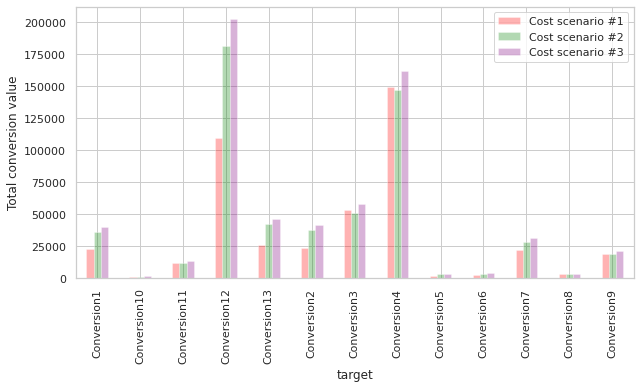

In [ ]:
by_conversion_Q3 = pd.concat([
simulated_conv_Q3_A2.groupby('target')['value'].sum(),
simulated_conv_Q3_A3.groupby('target')['value'].sum(),
simulated_conv_Q3_A4.groupby('target')['value'].sum(),
], axis=1)
by_conversion_Q3.columns = ['Cost scenario #1', 'Cost scenario #2', 'Cost scenario #3']
by_conversion_Q3.plot(kind='bar', color=['red', 'green', 'purple'], alpha=0.3, figsize=(10,5), ylabel='Total conversion value')

In [ ]:
draw_sankey(simulated_A2_value, '[Q3-1] Cost scenario #1', 800, 500)
draw_sankey(simulated_A3_value, '[Q3-2] Cost scenario #2', 800, 500)
draw_sankey(simulated_A4_value, '[Q3-3] Cost scenario #3', 800, 500)

#### Q4

In [ ]:
# Simulate values reach conversion
# (1) with new budget assingnment: all channel cost is the same + conversion value cascading
apply_assumption(6)
simulated_Q4_A6 = flow_simulation(M=1000, input_field='expected_value', output_field='conversion_value')

# (2) with new budget assingnment: Social media cost = 50% other channels + conversion value cascading
apply_assumption(7)
simulated_Q4_A7 = flow_simulation(M=1000, input_field='expected_value', output_field='conversion_value')

# (3) with new budget assingnment: E-commerce = 3 times of newspaper + conversion value cascading
apply_assumption(8)
simulated_Q4_A8 = flow_simulation(M=1000, input_field='expected_value', output_field='conversion_value')

Processing 0/1000...
Time taken: 70.53741884231567 seconds
Processing 0/1000...
Time taken: 71.48876523971558 seconds
Processing 0/1000...
Time taken: 71.12055969238281 seconds


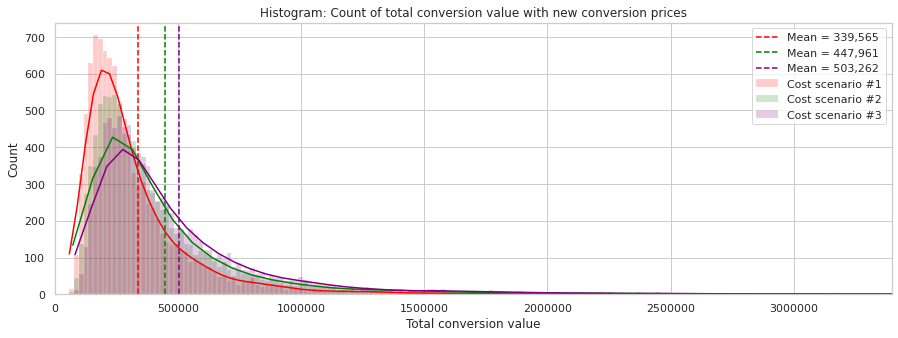

In [ ]:
# Compare sum of total flow
# simulated_conv_Q4_A6 = drop_non_conversion(simulated_Q4_A6)
# simulated_conv_Q4_A7 = drop_non_conversion(simulated_Q4_A7)
# simulated_conv_Q4_A8 = drop_non_conversion(simulated_Q4_A8)
simulated_conv_Q4_A6 = drop_non_conversion(simulated_A6)
simulated_conv_Q4_A7 = drop_non_conversion(simulated_A7)
simulated_conv_Q4_A8 = drop_non_conversion(simulated_A8)

# 차트 생성용 데이터
y_1 = simulated_conv_Q4_A6.sum(axis=0)[:10000].astype(float)
y_2 = simulated_conv_Q4_A7.sum(axis=0)[:10000].astype(float)
y_3 = simulated_conv_Q4_A8.sum(axis=0)[:10000].astype(float)

# x축 범위를 제한
y_data = pd.DataFrame(y_3, columns=['raw'])
y_data['rank'] = y_data['raw'].rank(pct=True)
y_data.sort_values(by='raw', ascending=False, inplace=True)
cutoff = y_data[y_data['rank'] > 0.995]

plt.figure(figsize=(15,5))
bins = np.histogram_bin_edges(y_1, bins='auto')
sns.histplot(y_1, color='red', bins=bins, alpha=0.2, kde=True, label='Cost scenario #1')
plt.axvline(y_1.mean(), color='red', linestyle='--', label=f'Mean = {y_1.mean():,.0f}')
sns.histplot(y_2, color='green', bins=bins, alpha=0.2, kde=True, label='Cost scenario #2')
plt.axvline(y_2.mean(), color='green', linestyle='--', label=f'Mean = {y_2.mean():,.0f}')
sns.histplot(y_3, color='purple', bins=bins, alpha=0.2, kde=True, label='Cost scenario #3')
plt.axvline(y_3.mean(), color='purple', linestyle='--', label=f'Mean = {y_3.mean():,.0f}')

plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlim(0, cutoff['raw'].min())
plt.xlabel('Total conversion value')
plt.title('Histogram: Count of total conversion value with new conversion prices')
plt.legend()
plt.show()

In [ ]:
# LTA model

# last touch importance = proportion of value to conversion
apply_assumption(0)
simulated_Q4_A0 = flow_simulation(M=1000,
    input_field='expected_value', output_field='value_new',
)

simulated_conv_Q4_A0 = drop_non_conversion(simulated_Q4_A0)
last_touches = simulated_conv_Q4_A0[['source', 'value']].groupby('source').sum()
last_touches['value_percent'] = last_touches['value'] / last_touches['value'].sum() * 100
last_touches['new_bugdet_assignment'] = 3400 * last_touches['value_percent'] / 100
last_touches

Processing 0/1000...
Time taken: 70.78858876228333 seconds


,value,value_percent,new_bugdet_assignment
source,,,
Blogger2,539.56,19.72,670.33
Email1,10.27,0.38,12.76
Newspaper1,4.87,0.18,6.05
PriceCompare,847.62,30.97,"1,053.05"
Retargeting1,"1,090.17",39.84,"1,354.40"
SNS4,1.17,0.04,1.46
Youtuber2,150.27,5.49,186.69
Youtuber5,92.76,3.39,115.25


In [ ]:
# (4-4) LTA only
apply_assumption(5)
simulated_Q4_A5 = flow_simulation(M=1000, input_field='expected_value', output_field='conversion_value')

Processing 0/1000...
Time taken: 71.52622056007385 seconds


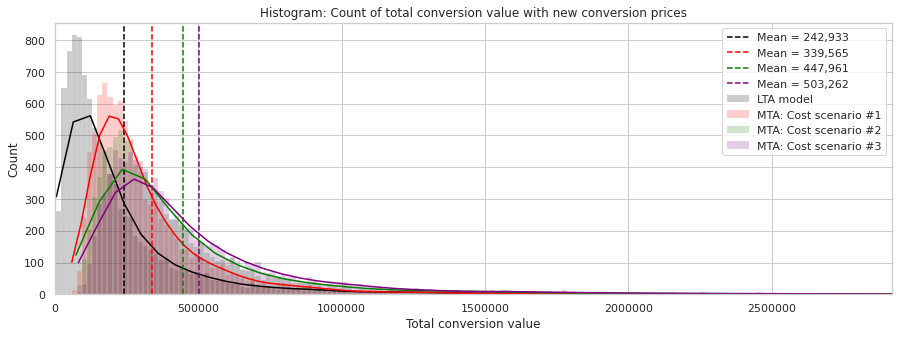

In [ ]:
# Compare sum of total flow
# simulated_conv_Q4_A5 = drop_non_conversion(simulated_Q4_A5)
# simulated_conv_Q4_A6 = drop_non_conversion(simulated_Q4_A6)
# simulated_conv_Q4_A7 = drop_non_conversion(simulated_Q4_A7)
# simulated_conv_Q4_A8 = drop_non_conversion(simulated_Q4_A8)
simulated_conv_Q4_A5 = drop_non_conversion(simulated_A5)
simulated_conv_Q4_A6 = drop_non_conversion(simulated_A6)
simulated_conv_Q4_A7 = drop_non_conversion(simulated_A7)
simulated_conv_Q4_A8 = drop_non_conversion(simulated_A8)

# 차트 생성용 데이터
y_1 = simulated_conv_Q4_A5.sum(axis=0)[:10000].astype(float)
y_2 = simulated_conv_Q4_A6.sum(axis=0)[:10000].astype(float)
y_3 = simulated_conv_Q4_A7.sum(axis=0)[:10000].astype(float)
y_4 = simulated_conv_Q4_A8.sum(axis=0)[:10000].astype(float)

# x축 범위를 제한
y_data = pd.DataFrame(y_1, columns=['raw'])
y_data['rank'] = y_data['raw'].rank(pct=True)
y_data.sort_values(by='raw', ascending=False, inplace=True)
cutoff = y_data[y_data['rank'] > 0.997]

plt.figure(figsize=(15,5))
bins = np.histogram_bin_edges(y_1, bins='auto')
sns.histplot(y_1, color='black', bins=bins, alpha=0.2, kde=True, label='LTA model')
plt.axvline(y_1.mean(), color='black', linestyle='--', label=f'Mean = {y_1.mean():,.0f}')
sns.histplot(y_2, color='red', bins=bins, alpha=0.2, kde=True, label='MTA: Cost scenario #1')
plt.axvline(y_2.mean(), color='red', linestyle='--', label=f'Mean = {y_2.mean():,.0f}')
sns.histplot(y_3, color='green', bins=bins, alpha=0.2, kde=True, label='MTA: Cost scenario #2')
plt.axvline(y_3.mean(), color='green', linestyle='--', label=f'Mean = {y_3.mean():,.0f}')
sns.histplot(y_4, color='purple', bins=bins, alpha=0.2, kde=True, label='MTA: Cost scenario #3')
plt.axvline(y_4.mean(), color='purple', linestyle='--', label=f'Mean = {y_4.mean():,.0f}')

plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlim(0, cutoff['raw'].min())
plt.xlabel('Total conversion value')
plt.title('Histogram: Count of total conversion value with new conversion prices')
plt.legend()
plt.show()

#### Q5

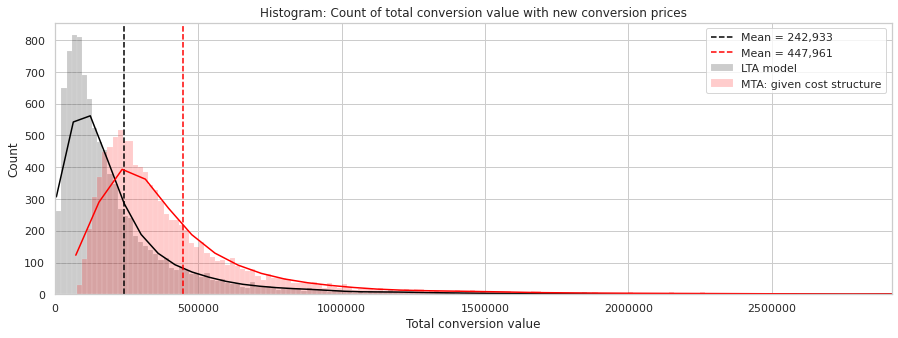

In [ ]:
# Compare sum of total flow
# simulated_conv_Q5_A5 = drop_non_conversion(simulated_Q4_A5)
# simulated_conv_Q5_A9 = drop_non_conversion(simulated_Q4_A7)
simulated_conv_Q5_A5 = drop_non_conversion(simulated_A5)
simulated_conv_Q5_A9 = drop_non_conversion(simulated_A9)

# 차트 생성용 데이터
y_1 = simulated_conv_Q5_A5.sum(axis=0)[:10000].astype(float)
y_2 = simulated_conv_Q5_A9.sum(axis=0)[:10000].astype(float)

# x축 범위를 제한
y_data = pd.DataFrame(y_1, columns=['raw'])
y_data['rank'] = y_data['raw'].rank(pct=True)
y_data.sort_values(by='raw', ascending=False, inplace=True)
cutoff = y_data[y_data['rank'] > 0.997]

plt.figure(figsize=(15,5))
bins = np.histogram_bin_edges(y_1, bins='auto')
sns.histplot(y_1, color='black', bins=bins, alpha=0.2, kde=True, label='LTA model')
plt.axvline(y_1.mean(), color='black', linestyle='--', label=f'Mean = {y_1.mean():,.0f}')
sns.histplot(y_2, color='red', bins=bins, alpha=0.2, kde=True, label='MTA: given cost structure')
plt.axvline(y_2.mean(), color='red', linestyle='--', label=f'Mean = {y_2.mean():,.0f}')

plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlim(0, cutoff['raw'].min())
plt.xlabel('Total conversion value')
plt.title('Histogram: Count of total conversion value with new conversion prices')
plt.legend()
plt.show()

#### Q6

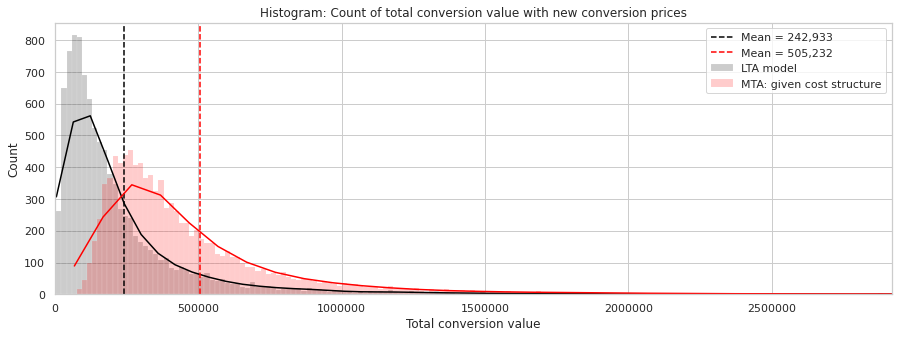

In [ ]:
# Compare sum of total flow
# simulated_conv_Q6_A5 = drop_non_conversion(simulated_Q4_A5)
# simulated_conv_Q6_A10 = drop_non_conversion(simulated_Q4_A8)
simulated_conv_Q6_A5 = drop_non_conversion(simulated_A5)
simulated_conv_Q6_A10 = drop_non_conversion(simulated_A10)

# 차트 생성용 데이터
y_1 = simulated_conv_Q6_A5.sum(axis=0)[:10000].astype(float)
y_2 = simulated_conv_Q6_A10.sum(axis=0)[:10000].astype(float)

# x축 범위를 제한
y_data = pd.DataFrame(y_1, columns=['raw'])
y_data['rank'] = y_data['raw'].rank(pct=True)
y_data.sort_values(by='raw', ascending=False, inplace=True)
cutoff = y_data[y_data['rank'] > 0.997]

plt.figure(figsize=(15,5))
bins = np.histogram_bin_edges(y_1, bins='auto')
sns.histplot(y_1, color='black', bins=bins, alpha=0.2, kde=True, label='LTA model')
plt.axvline(y_1.mean(), color='black', linestyle='--', label=f'Mean = {y_1.mean():,.0f}')
sns.histplot(y_2, color='red', bins=bins, alpha=0.2, kde=True, label='MTA: given cost structure')
plt.axvline(y_2.mean(), color='red', linestyle='--', label=f'Mean = {y_2.mean():,.0f}')

plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlim(0, cutoff['raw'].min())
plt.xlabel('Total conversion value')
plt.title('Histogram: Count of total conversion value with new conversion prices')
plt.legend()
plt.show()

#### Q7

In [ ]:
# Shapley value adjustment (1)
# recalcuate_shapley(11, 100, input_field='expected_value', output_field='conversion_value')

# Budget reallocation

# all unique paths exists
all_paths = paths_split.copy()[['source', 'target', 'source_all_ordered']]
all_paths.drop_duplicates('source_all_ordered', inplace=True)

# simulate new conversion values for each path based on the new assumption
raise Exception
# CAUTION: "as-was" budget assignment inherited from assumption 10 is needed
apply_assumption(11)
recalculate_path_score(M=[100], input_field='expected_value', output_field='conversion_value')
all_paths_Q7 = all_paths.copy()

Time taken: 887.8588101863861 seconds: M=100


In [ ]:
# calculate Shapley value by subgame approach
shapley_input = all_paths_Q7.loc[:, ~all_paths.columns.isin(['soruce', 'target'])].set_index('source_all_ordered')

shapley_value = calculate_shapley_by_subgame(shapley_input['value_100'].to_frame())
shapley_value['shapley_value_percent'] = shapley_value['shapley_value'] / shapley_value['shapley_value'].sum()
shapley_value.sort_values(by='shapley_value_percent', ascending=False, inplace=True)

# Plan a new budget assignment
shapley_value['new_bugdet_assignment'] = 3400 * shapley_value['shapley_value_percent']
shapley_value

,shapley_value,shapley_value_percent,new_bugdet_assignment
Retargeting1,"329,707.03",0.25,859.06
Influencer7,"275,818.52",0.21,718.65
Retargeting2,"184,231.49",0.14,480.02
SNS4,"74,417.77",0.06,193.90
Blogger2,"73,285.70",0.06,190.95
Search1,"67,039.08",0.05,174.67
Youtuber1,"36,945.02",0.03,96.26
Influencer5,"35,321.61",0.03,92.03
Youtuber2,"34,811.41",0.03,90.70
Youtuber5,"30,912.97",0.02,80.54


In [ ]:
# (7-1) Doubled price for Product 10 and 11
# CAUTION: used "as-to-be" budget assignment reaasinged by new Shapley value
apply_assumption(10)
simulated_Q7_A10 = flow_simulation(M=10000, input_field='expected_value', output_field='conversion_value')
apply_assumption(11)
simulated_Q7_A11 = flow_simulation(M=10000, input_field='expected_value', output_field='conversion_value')

Processing 0/10000...
Processing 1000/10000...
Processing 2000/10000...
Processing 3000/10000...
Processing 4000/10000...
Processing 5000/10000...
Processing 6000/10000...
Processing 7000/10000...
Processing 8000/10000...
Processing 9000/10000...
Time taken: 726.5856912136078 seconds


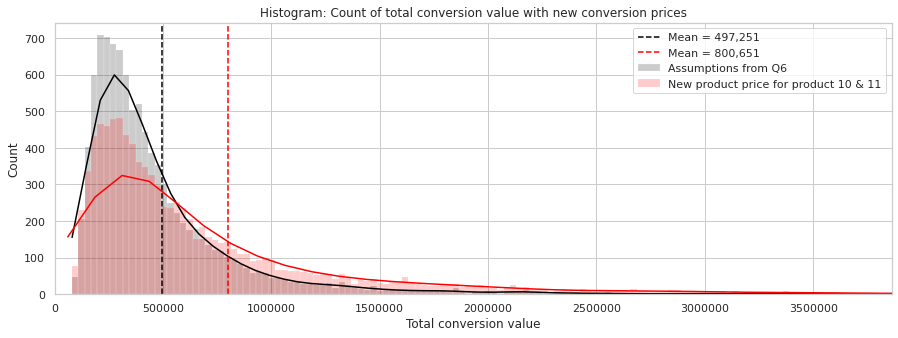

In [ ]:
# Compare sum of total flow
simulated_conv_Q7_A10 = drop_non_conversion(simulated_Q7_A10)
simulated_conv_Q7_A11 = drop_non_conversion(simulated_Q7_A11)
# simulated_conv_Q7_A10 = drop_non_conversion(simulated_A10)
# simulated_conv_Q7_A11 = drop_non_conversion(simulated_A11)

# 차트 생성용 데이터
y_1 = simulated_conv_Q7_A10.sum(axis=0)[:10000].astype(float)
y_2 = simulated_conv_Q7_A11.sum(axis=0)[:10000].astype(float)

# x축 범위를 제한
y_data = pd.DataFrame(y_1, columns=['raw'])
y_data['rank'] = y_data['raw'].rank(pct=True)
y_data.sort_values(by='raw', ascending=False, inplace=True)
cutoff = y_data[y_data['rank'] > 0.997]

plt.figure(figsize=(15,5))
bins = np.histogram_bin_edges(y_1, bins='auto')
sns.histplot(y_1, color='black', bins=bins, alpha=0.2, kde=True, label='Assumptions from Q6')
plt.axvline(y_1.mean(), color='black', linestyle='--', label=f'Mean = {y_1.mean():,.0f}')
sns.histplot(y_2, color='red', bins=bins, alpha=0.2, kde=True, label='New product price for product 10 & 11')
plt.axvline(y_2.mean(), color='red', linestyle='--', label=f'Mean = {y_2.mean():,.0f}')

plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlim(0, cutoff['raw'].min())
plt.xlabel('Total conversion value')
plt.title('Histogram: Count of total conversion value with new conversion prices')
plt.legend()
plt.show()

<AxesSubplot:xlabel='target', ylabel='Total conversion value'>

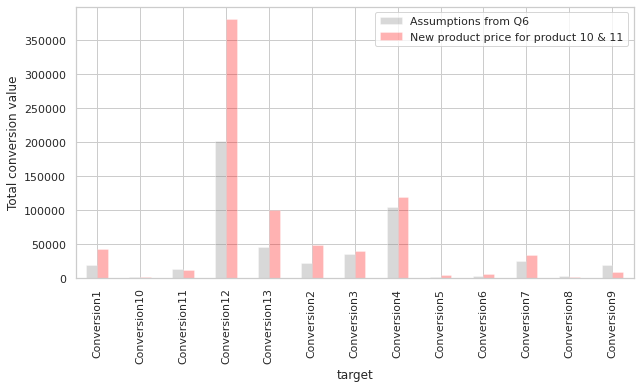

In [ ]:
by_conversion_Q7 = pd.concat([
simulated_conv_Q7_A10.groupby('target')['value'].sum(),
simulated_conv_Q7_A11.groupby('target')['value'].sum(),
], axis=1)
by_conversion_Q7.columns = ['Assumptions from Q6', 'New product price for product 10 & 11']
by_conversion_Q7.plot(kind='bar', color=['grey', 'red'], alpha=0.3, figsize=(10,5), ylabel='Total conversion value')

#### Q8

In [ ]:
# (8) Refund attribution
draw_sankey(simulated_A10_value, '[Q8] With all updated assumptions, before price raise', 1000, 600)

In [ ]:
# Filter out channels lead to Conversion 10 or 11
related_nodes = link_df[link_df['target'].isin(['Conversion10', 'Conversion11','PriceCompare','Youtuber1','Youtuber4','Search3'])]['source'].to_list()

apply_assumption(10)
simulated_Q8 = flow_simulation(M=1000,
    input_field='expected_value', output_field='value_new',
    selected_path=related_nodes,
    hide_unselected=True,
)
draw_sankey(simulated_Q8, '[Q8] Channels impacting Conversion 10 & 11, before price raise', 1000, 600)

Processing 0/1000...
Time taken: 75.72622489929199 seconds


In [ ]:
# Shapley value adjustment (2)

# Budget reallocation

# all unique paths exists
all_paths = paths_split.copy()[['source', 'target', 'source_all_ordered']]
all_paths.drop_duplicates('source_all_ordered', inplace=True)

# simulate new conversion values for each path based on the new assumption
raise Exception
# CAUTION: "as-was" budget assignment inherited from assumption 10 is needed
apply_assumption(12)
recalculate_path_score(M=[100], input_field='expected_value', output_field='conversion_value')
all_paths_Q8 = all_paths.copy()

Time taken: 879.5347127914429 seconds: M=100


In [ ]:
# calculate Shapley value by subgame approach
shapley_input = all_paths_Q8.loc[:, ~all_paths.columns.isin(['soruce', 'target'])].set_index('source_all_ordered')

shapley_value = calculate_shapley_by_subgame(shapley_input['value_100'].to_frame())
shapley_value['shapley_value_percent'] = shapley_value['shapley_value'] / shapley_value['shapley_value'].sum()
shapley_value.sort_values(by='shapley_value_percent', ascending=False, inplace=True)

# Plan a new budget assignment
shapley_value['new_bugdet_assignment'] = 3400 * shapley_value['shapley_value_percent']
shapley_value

,shapley_value,shapley_value_percent,new_bugdet_assignment
Retargeting1,"624,801.54",0.31,"1,044.54"
Influencer7,"588,282.32",0.29,983.49
Retargeting2,"331,934.24",0.16,554.93
SNS4,"156,627.07",0.08,261.85
Blogger2,"56,410.62",0.03,94.31
Search1,"53,193.08",0.03,88.93
Youtuber5,"38,224.65",0.02,63.90
AdWordsKeyword2,"34,258.75",0.02,57.27
AdWordsKeyword3,"30,656.46",0.02,51.25
Youtuber1,"26,997.08",0.01,45.13


In [ ]:
# (8)
# CAUTION: used "as-to-be" budget assignment reaasinged by new Shapley value
apply_assumption(12)
simulated_Q8_A12 = flow_simulation(M=10000, input_field='expected_value', output_field='conversion_value')

Processing 0/10000...
Processing 1000/10000...
Processing 2000/10000...
Processing 3000/10000...
Processing 4000/10000...
Processing 5000/10000...
Processing 6000/10000...
Processing 7000/10000...
Processing 8000/10000...
Processing 9000/10000...
Time taken: 721.7450950145721 seconds


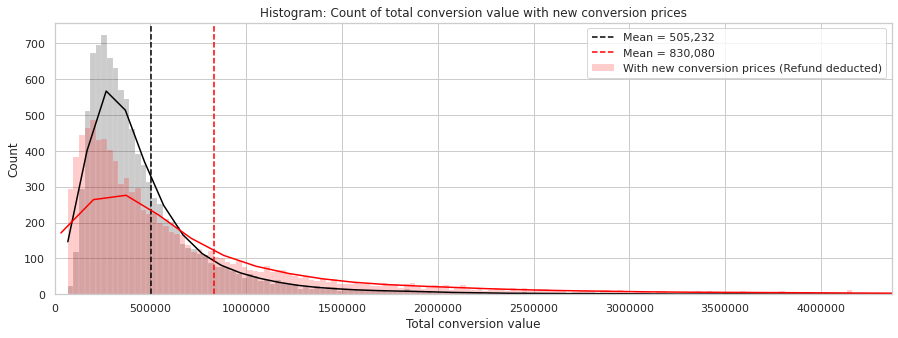

In [ ]:
# Compare sum of total flow
simulated_conv_Q8_A10 = drop_non_conversion(simulated_A10)
simulated_conv_Q8_A12 = drop_non_conversion(simulated_Q8_A12)
# simulated_conv_Q8_A12 = drop_non_conversion(simulated_A12)

y_1 = simulated_conv_Q8_A10.sum(axis=0)[:10000].astype(float)
y_2 = simulated_conv_Q8_A12.sum(axis=0)[:10000].astype(float)

y_data = pd.DataFrame(y_1, columns=['raw'])
y_data['rank'] = y_data['raw'].rank(pct=True)
y_data.sort_values(by='raw', ascending=False, inplace=True)
cutoff = y_data[y_data['rank'] > 0.997]

plt.figure(figsize=(15,5))
bins = np.histogram_bin_edges(y_1, bins='auto')
sns.histplot(y_1, color='black', bins=bins, alpha=0.2, kde=True, label='Assumptions from Q6')
plt.axvline(y_1.mean(), color='black', linestyle='--', label=f'Mean = {y_1.mean():,.0f}')
sns.histplot(y_2, color='red', bins=bins, alpha=0.2, kde=True, label='With new conversion prices (Refund deducted)')
plt.axvline(y_2.mean(), color='red', linestyle='--', label=f'Mean = {y_2.mean():,.0f}')

plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlim(0, cutoff['raw'].min())
plt.xlabel('Total conversion value')
plt.title('Histogram: Count of total conversion value with new conversion prices')
plt.legend()
plt.show()

<AxesSubplot:xlabel='target', ylabel='Total conversion value'>

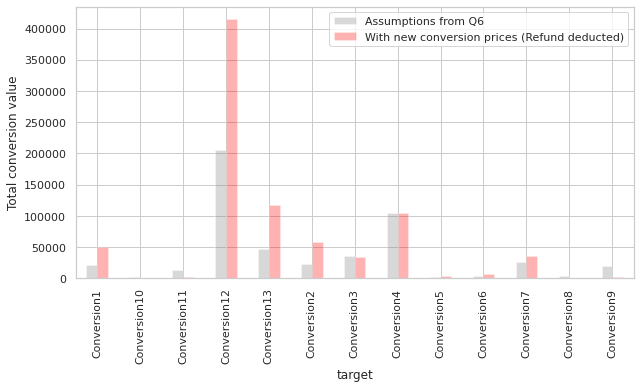

In [ ]:
by_conversion_Q8 = pd.concat([
simulated_conv_Q8_A10.groupby('target')['value'].sum(),
simulated_conv_Q8_A12.groupby('target')['value'].sum(),
], axis=1)
by_conversion_Q8.columns = ['Assumptions from Q6', 'With new conversion prices (Refund deducted)']
by_conversion_Q8.plot(kind='bar', color=['grey', 'red'], alpha=0.3, figsize=(10,5), ylabel='Total conversion value')

#### Q9-10

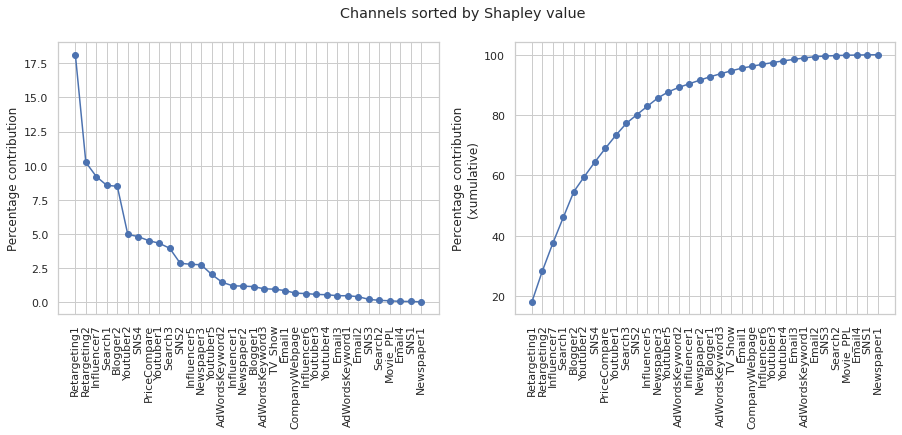

In [ ]:
# Elbow chart approach:
# Explained percentage contribution to conversion value by channel
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Channels sorted by Shapley value')

axs[0].plot(path_score_shapley.index, path_score_shapley['shapley_value_percent'], marker='o')
axs[0].tick_params(axis='x', labelrotation=90)
axs[0].set_ylabel('Percentage contribution')

path_score_shapley['shapley_value_percent_cumulative'] = path_score_shapley['shapley_value_percent'].cumsum()
axs[1].plot(path_score_shapley.index, path_score_shapley['shapley_value_percent_cumulative'], marker='o')
axs[1].tick_params(axis='x', labelrotation=90)
axs[1].set_ylabel('Percentage contribution\n(xumulative)')
plt.show()

In [ ]:
# Which channles should be cut off?
least_contributing_nodes = path_score_shapley.sort_values(by='shapley_value', ascending=True)['shapley_value_percent'].to_frame()[:20]
least_contributing_nodes['channel_type'] = least_contributing_nodes.index.map(node_df.set_index('name')['category'])
least_contributing_nodes

,shapley_value_percent,channel_type
Newspaper1,0.04,Paid
SNS1,0.06,Social
Email4,0.07,Organic
Movie_PPL,0.11,Paid
Search2,0.15,Organic
SNS3,0.22,Social
Email2,0.41,Organic
AdWordsKeyword1,0.48,Paid
Email3,0.48,Organic
Youtuber4,0.56,Social


In [ ]:
# Check where should we stop: channle drop-out simulation
M = 1000
apply_assumption(13)

result = pd.DataFrame()
for i in range(len(least_contributing_nodes)):
    result[i+1] = drop_non_conversion(flow_simulation(M=M,
        input_field='expected_value', output_field='conversion_value',
        drop_out=least_contributing_nodes[:i+1].index.to_list(),
        verbose=False
    )).sum(axis=0)[:M].astype(float)

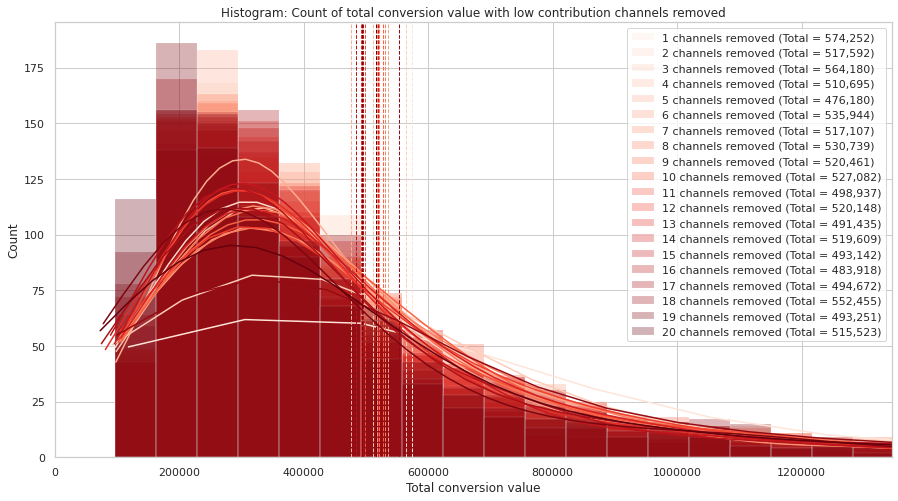

In [ ]:
# Despite its lower contribution, total conversion value will diminished by firing too many channels
# as long as we cannot find new channles outperforms the existing ones for sure
y_data = result.iloc[:,1].to_frame()
y_data.columns = ['raw']
y_data['rank'] = y_data['raw'].rank(pct=True)
y_data.sort_values(by='raw', ascending=False, inplace=True)
cutoff = y_data[y_data['rank'] > 0.95]

plt.figure(figsize=(15,8))
cmap = iter(cm.Reds(np.linspace(0.1, 1, len(least_contributing_nodes))))
bins = np.histogram_bin_edges(result.iloc[:,1], bins='auto')
for i in range(len(least_contributing_nodes)):
    color_ = next(cmap)
    sns.histplot(result.iloc[:,i], color=color_, bins=bins, alpha=0.3, kde=True, label=f'{i+1} channels removed (Total = {result.iloc[:,i].mean():,.0f})')
    plt.axvline(result.iloc[:,i].mean(), color=color_, linestyle='--', linewidth=1)

plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlim(0, cutoff['raw'].min())
plt.xlabel('Total conversion value')
plt.title('Histogram: Count of total conversion value with low contribution channels removed')
plt.legend()
plt.show()

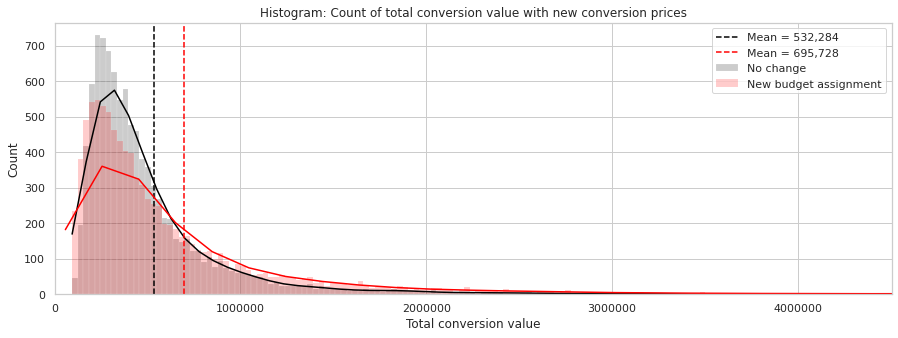

In [ ]:
# Compare sum of total flow
simulated_conv_Q10_A12 = drop_non_conversion(simulated_A12)
simulated_conv_Q10_A13 = drop_non_conversion(simulated_A13)

# 차트 생성용 데이터
y_1 = simulated_conv_Q10_A12.sum(axis=0)[:10000].astype(float)
y_2 = simulated_conv_Q10_A13.sum(axis=0)[:10000].astype(float)

# x축 범위를 제한
y_data = pd.DataFrame(y_1, columns=['raw'])
y_data['rank'] = y_data['raw'].rank(pct=True)
y_data.sort_values(by='raw', ascending=False, inplace=True)
cutoff = y_data[y_data['rank'] > 0.997]

plt.figure(figsize=(15,5))
bins = np.histogram_bin_edges(y_1, bins='auto')
sns.histplot(y_1, color='black', bins=bins, alpha=0.2, kde=True, label='No change')
plt.axvline(y_1.mean(), color='black', linestyle='--', label=f'Mean = {y_1.mean():,.0f}')
sns.histplot(y_2, color='red', bins=bins, alpha=0.2, kde=True, label='New budget assignment')
plt.axvline(y_2.mean(), color='red', linestyle='--', label=f'Mean = {y_2.mean():,.0f}')

plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlim(0, cutoff['raw'].min())
plt.xlabel('Total conversion value')
plt.title('Histogram: Count of total conversion value with new conversion prices')
plt.legend()
plt.show()

In [ ]:
# Budget allocation is being optimized by repeating reassigning the imporatnce based on Shapley value
previous_shapley = calculate_shapley_by_subgame(path_reserve[12][['source_all_ordered', 'value_100']].set_index('source_all_ordered')).sort_values('shapley_value', ascending=False)
previous_shapley['shapley_value_percent'] = previous_shapley['shapley_value'] / previous_shapley['shapley_value'].sum()
previous_shapley['budget_assignment'] = 3400 * previous_shapley['shapley_value_percent']
previous_shapley['shapley_value_percent_cumulative'] = previous_shapley['shapley_value_percent'].cumsum()
channel_to_fire = previous_shapley[previous_shapley['budget_assignment'] <= 1.0].index.to_list()

In [ ]:
shapley_value = recalcuate_shapley(
    assumption=13,
    M=100,
    input_field='expected_value',
    output_field='conversion_value',
    channel_to_fire=channel_to_fire
)
shapley_value['shapley_value_percent_cumulative'] = shapley_value['shapley_value_percent'].cumsum()

Time taken: 884.3424997329712 seconds: M=100


In [ ]:
previous_shapley2 = calculate_shapley_by_subgame(path_reserve[11][['source_all_ordered', 'value_100']].set_index('source_all_ordered')).sort_values('shapley_value', ascending=False)
previous_shapley2['shapley_value_percent'] = previous_shapley2['shapley_value'] / previous_shapley2['shapley_value'].sum()
previous_shapley2['shapley_value_percent_cumulative'] = previous_shapley2['shapley_value_percent'].cumsum()

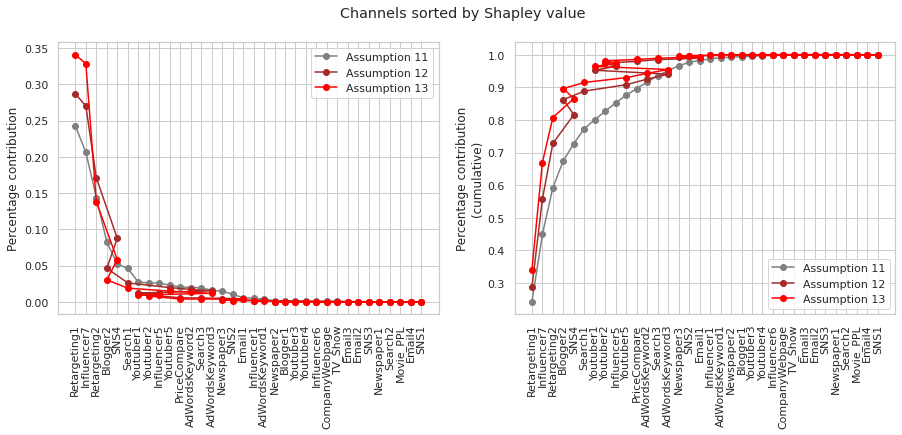

In [ ]:
# Because some top efficiency channels outperform, (by linear assumption)
# budget assignment is getting more concentrated
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
fig.suptitle('Channels sorted by Shapley value')

axs[0].plot(previous_shapley2.index, previous_shapley2['shapley_value_percent'], color='grey', marker='o', label='Assumption 11')
axs[0].plot(previous_shapley.index, previous_shapley['shapley_value_percent'], color='brown', marker='o', label='Assumption 12')
axs[0].plot(shapley_value.index, shapley_value['shapley_value_percent'], color='red', marker='o', label='Assumption 13')
axs[0].tick_params(axis='x', labelrotation=90)
axs[0].set_ylabel('Percentage contribution')
axs[0].legend()

axs[1].plot(previous_shapley2.index, previous_shapley2['shapley_value_percent_cumulative'], color='grey', marker='o', label='Assumption 11')
axs[1].plot(previous_shapley.index, previous_shapley['shapley_value_percent_cumulative'], color='brown', marker='o', label='Assumption 12')
axs[1].plot(shapley_value.index, shapley_value['shapley_value_percent_cumulative'], color='red', marker='o', label='Assumption 13')
axs[1].tick_params(axis='x', labelrotation=90)
axs[1].set_ylabel('Percentage contribution\n(cumulative)')
axs[1].legend()

plt.show()